<a href="https://colab.research.google.com/github/nv-hiep/nguyen_et_al_2019/blob/main/HT03_data_and_the_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import pickle

from tqdm import tqdm
from time import time
from PIL import Image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [102]:
from scipy.io import readsav
from astropy.io import fits

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# !pip install latex
# ! apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng

# 2. Connect to Google Drive

In [4]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed Jun 30 14:25:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [10]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019/
!ls

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019
fitted_parameters			  images
HI_decomposition_nguyen_et_al_2019.ipynb  Plot_Gaussian_and_pseudo_Voigt.ipynb
HI_spectra				  scripts
HT03_data_and_the_fit.ipynb		  Source_list.csv
HT03_MS					  Source_list.gsheet


In [7]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019


## 3. Paths to Data Directories

In [119]:
PROJECT_PATH       = '/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019'
SPECTRA_PATH       = os.path.join( PROJECT_PATH, 'HI_spectra' )
FITTED_PARAMS_PATH = os.path.join( PROJECT_PATH, 'fitted_parameters' )
HT03_PATH          = os.path.join( PROJECT_PATH, 'HT03_MS' )
HASLAM_PATH        = os.path.join( PROJECT_PATH, 'Haslam' )

CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_Gaussian_parameters.fits' )
WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_Gaussian_parameters.fits' )

psV_CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_pseudoVoigt_parameters.fits' )
psV_WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_pseudoVoigt_parameters.fits' )

HT03_HI_SPECTRA = os.path.join( HT03_PATH, 'MS_HI_spectra.npy' )
HT03_FIT_PARAMS = os.path.join( HT03_PATH, 'MS_gfit_params_dict.npy' )
TB_408_SAV      = os.path.join( HASLAM_PATH, 'tb_408.sav' )
HT03_PLOTS      = os.path.join( HT03_PATH, 'plots' )

# 4. Background Temperature from 408MHz (Haslam et al.)

In [100]:
## Retreive a SINGLE value of 408 t_b from haslam et al. ##
 #
 # params float ell Galactic-longitude
 # params float bee Galactic-latitude
 #
 # return float Tbg_408 Background-Temperature at (l,b)
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def get_tb_408(ell,bee,tb_408):
	iell= round(( modangle(ell)/360.)* 1080.)
	ibee= round( (( modangle( bee, 360., negpos=True)+90.)/180.)* 540)

	return tb_408[int(ibee), int(iell)]

## Convert angle to a specified range by finding the angle modulo the extent of the range. ##
 #
 # params 
 # params 
 #
 # return 
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def modangle(angle, extent=360., negpos=False):
	offset = 0.
	if(negpos):
		offset = extent/2.

	return ((((angle-offset) % extent) + extent) % extent) - offset

In [103]:
## ---Compute Tsky at the source position [**predict_sync method currently not working, 
## ---so I just set a generic value here, will fix in the future]
## @galactic_coordinates.pro
## print, 'gl gb', gl, ' ', gb
## tsky=predict_sync(gl,gb, nu=1.4, /interp)+2.725 
# tsky  = 2.8 ## 3.41

inf408 = readsav(TB_408_SAV)
# tsky   = 2.725 + txtDat.get_tb_408(ell, bee, inf408.tb_408)*(408./1420.405)**2.8 # Tbg from 408MHz

# 5. Necessary functions

In [106]:
## Multiple (N) Gaussians + offset. ##
 #
 #+
 #CALCULATE THE EMISSION EXPECTED FROM A BUNCH OF CLOUDS IN ARBITRARY
 #ORDER ALONG THE LINE OF SIGHT, AND ALSO A BUNCH OF ZERO-OPACITY EMISSION
 #COMPONENTS, and a continuum from behind everything.

 # -----------CALLING SEQUENCE--------------------------------
 #tb_exp, xdata, zrocnm, taucnm, cencnm, widcnm, tspincnm, ordercnm, $
 #	continuum, hgtwnm, cenwnm, widwnm, fwnm, $
 #	tb_cont, tb_wnm_tot, tb_cnm_tot, tb_tot, exp_tausum
 #
 #CNM QUANTITIES:
 #    ZROCNM is a single number, not a vector # it's the freq-independent
 #           part of the CNM opacity, and should normally be zero.
 #    TAUCNM is the vector of central optical depths of CNM component
 #    CENCNM, WIDCNM, TSPINCNM are vectors for CNM comps. widths are FWHM
 #    ORDERCNM is order along los. if there are 3 clouds, order might be
 #    [0,2,1], with G-component 0 being CLOSESTest and G-comp 1 being FURTHEST.
 #
 #CONTINUUM is the continuum TB, assumed to come from behind all CNM.
 #
 #WNM QUANS:
 #    HGTWNM, CENWNM, WIDWNM, FWNM # all self-explanatory vectors.
 #    FWNM # all self-explanatory vectors.
 #
 #    FWNM IS THE FRACTION OF THE WNM EMISSION THAT LIES IN FRONT OF THE
 #          COLD ABSORBING CLOUDS.  each wnm component lies either in front
 #          of or behind ALL the CNM components. so if there are 3 WNM comps
 #          numbered 0 to 2, FWNM=[0,0.5,1] means that the first lies 
 #          behind all CNM, the second behind half of it, and the third 
 #          lies in front of all CNM.
 #
 # -----------INPUTS ARE--------------------------------
 #       TB_CONT is the continuum, absorbed by the CNM
 #	TB_WNM_TOT, the emission from the ensemble of WNM clouds as seen by
 #               the observer, with ones behind the CNM absorbed. This 
 #               includes the continuum, also absorbed.
 #       TB_CNM_TOT, the emission from the ensemble of CNM clouds as seen by
 #               the observer, with ones behind others absorbed.
 #       tb_tot, the sum of the WNM and CNM...the total emission as seen
 #               by the observer
 #       EXP_TAUSUM, the total opacity from all CNM components.
 #
 #
 # -----------HISTORY-----------------------------------
 #3 MAY 00: CORRECTION: THE ZERO OFFSET WAS INCLUDED IN CALCULATING
 #	TB_WNM_TOT.
 #
 #10nov2009: the above correction assumes that there is continuum coming
 #           from in front of all cnm so none of it gets absorbed. we
 #           changed it so that it comes from behind all cnm, so it can
 #           represent the 3K background and other Galactic continuum.
 #           and it used to be called ZROWNM # now we call it CONTINUUM.
 #10nov2009: continuum updated # this version differs from previous ones in
 #           this regard.
 #-
 #
 # version 01/2017 
 # author Nguyen Van Hiep ##
def tb_exp(p, x, ordercnm, ncnm, nwnm):
	zrocnm   = p[0]
	zrownm   = p[1]

	hgtcnm   = p[2        : ncnm*1+2]
	cencnm   = p[ncnm*1+2 : ncnm*2+2]
	widcnm   = p[ncnm*2+2 : ncnm*3+2]
	tspincnm = p[ncnm*3+2 : ncnm*4+2]
	
	hgtwnm   = p[ncnm*4+2        : ncnm*4+2+nwnm*1]
	cenwnm   = p[ncnm*4+2+nwnm*1 : ncnm*4+2+nwnm*2]
	widwnm   = p[ncnm*4+2+nwnm*2 : ncnm*4+2+nwnm*3]
	fwnm     = p[ncnm*4+2+nwnm*3 : ncnm*4+2+nwnm*4]

	zro1     = zrocnm
	hgt1     = hgtcnm[ordercnm]
	cen1     = cencnm[ordercnm]
	wid1     = widcnm[ordercnm]
	tspin1   = tspincnm[ordercnm]

	#FIRST STEP IS TO CALCULATE THE OPACITY OF EACH COLD CLOUD...
	nchnl    = len(x)
	nrcnm    = len(hgt1)
	taucnmxx = np.zeros( (nrcnm, nchnl), dtype='float64' )

	for i, (hc,cc,wc) in enumerate( zip(hgt1, cen1, wid1) ):
		taucnmxx[i, :] = gfunc(x, zro1, hc, cc, wc)

	if(nrcnm != 1):
		tausum = np.sum( taucnmxx, 0) 
	else:
		tausum = taucnmxx[0]

	exp_tausum = np.exp( -tausum )
	tb_cont    = zrownm * exp_tausum


	# ********** NEXT CALCULATE THE WNM CONTRIBUTION ********************
	# WE EXPRESS THE WNM CONTRIBUTION AS A SUM OF GAUSSIANS:
	# 	FWNM, ZROWNM, HGTWNM, CENWNM, WIDWNM

	# THESE ARE SELF-EXPLANATORY EXCEPT FOR FWNM. 
	# 
	# THE CONTRIBUTION OF THE WNM COMPONENTS TO THE ANTENNA TEMP IS...
	# WNM CONTRIBUTION  = SUM, k FROM 0 TO K { G_WNMk [f_k + (1-f_k)exp(-tausum)]}
	# WHERE TAUSUM IS THE SUM OF THE OPACITIES OF ALL THE CLOUDS.

	tb_cont    = zrownm * exp_tausum
	tb_wnm_tot = np.zeros(nchnl, dtype='float64' )
	nrwnm      = len( hgtwnm )

	for hw,cw,ww,fw in zip(hgtwnm, cenwnm, widwnm, fwnm):
		tb_wnm_nrw = gfunc(x, 0., hw, cw, ww)
		tb_wnm_tot = tb_wnm_tot + tb_wnm_nrw*( fw + (1.- fw)*exp_tausum )

	# *************** NEXT CALCULATE THE CNM CONTRIBUTION ****************
	tb_cnm_tot = np.zeros( nchnl, dtype='float64' )

	for nrc in range(nrcnm):
		tausum_nrc  = np.sum( taucnmxx[0:nrc, :], 0)
		exp_tau_nrc = np.exp( -tausum_nrc )
		tb_cnm_tot  = tb_cnm_tot + tspin1[nrc] * (1. - np.exp(-taucnmxx[nrc, :]) ) * exp_tau_nrc
	## Endfor

	tb_tot = tb_cont + tb_cnm_tot + tb_wnm_tot

	return tb_tot, tb_cont, tb_cnm_tot, tb_wnm_tot

In [87]:
## Multiple (N) Gaussians + offset. ##
 #
 # params list  v    VLSR
 # params float zr   estimated constant zero offset of the data points.
 # params list  h    the array of N estimated heights of the Gaussians.
 # params list  v0   the array of N estimated centers of the Gaussians.
 # params list  w    the array of N estimated halfwidths of the Gaussians.
 #
 # return 1-D-array  tf  The calculated points.
 #
 # version 01/2017
 # author Nguyen Van Hiep ##
def gfunc(v, zr, h, v0, w):
	dp600 = np.float64(0.60056120)
	if(np.isscalar(v)):
		v  = np.array([v], dtype='float64')
	if(np.isscalar(h)):
		h  = np.array([h], dtype='float64')
	if(np.isscalar(v0)):
		v0 = np.array([v0], dtype='float64')
	if(np.isscalar(w)):
		w  = np.array([w], dtype='float64')

	#DETERMINE NR OF GAUSSIANS...
	ng = len(h)
	
	ret = 0.*v + zr
	for i in range(ng):
		if (w[i] > 0.):
			ret = ret + h[i]*np.exp(- ( (v-v0[i])/(dp600*w[i]))**2)

	return ret

# 6. MS data (HT03a)

In [77]:
## MS data
msdat     = np.load(HT03_HI_SPECTRA, encoding='latin1', allow_pickle=True).item()
mspars    = np.load(HT03_FIT_PARAMS, encoding='latin1', allow_pickle=True).item()

Spectral data of MS

In [79]:
msdata = {}
for sc, dat in msdat.items():
  k = sc.decode('utf-8')
  msdata[k] = dat

del msdat

In [97]:
msdata['3C75']

{'dec50': 5.8455,
 'emt': array([1.007538, 0.98264 , 1.013392, ..., 0.987367, 1.000144, 0.991872]),
 'gb': -44.9111,
 'gl': 170.2558,
 'ra50': 43.7714,
 'texp': array([-0.0929165,  0.199066 , -0.2059   , ...,  0.160845 ,  0.0496805,
         0.262789 ]),
 'vlsr': array([ 165.95,  165.79,  165.63, ..., -163.35, -163.51, -163.67])}

The fitted parameters from HT03

In [78]:
msparams = {}
for sc, dat in mspars.items():
  k = sc.decode('utf-8')
  msparams[k] = dat

del mspars

In [98]:
msparams['3C75']

{'cencnm': [-10.4, -5.8, 5.3],
 'cenwnm': [-10.0, 5.7],
 'fwnm': [0.49, 0.5],
 'hgtcnm': [0.682, 0.095, 0.113],
 'hgtwnm': [9.56, 14.09],
 'order': [0, 1, 2],
 'sigcencnm': [0.0, 0.1, 0.1],
 'sigcenwnm': [0.1, 0.0],
 'sigfwnm': [0.29, 0.29],
 'sighgtcnm': [0.006, 0.004, 0.003],
 'sighgtwnm': [0.16, 0.21],
 'sigtspin': [4.6284, 3.9161, 7.9466],
 'sigwidcnm': [0.02, 0.12, 0.13],
 'sigwidwnm': [0.18, 0.15],
 'tspin': [41.8324, 46.9208, 122.1235],
 'widcnm': [2.32, 2.74, 5.19],
 'widwnm': [9.79, 13.05]}

# 7. Plot the spectra


***********
3C33
Number of CNM components:  1
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C33 -4.3 0.025 8.91 451.5454

 (CEN, HGT, WID)
WNM 3C33 -42.9 0.38 22.23
WNM 3C33 -6.7 2.23 22.46
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


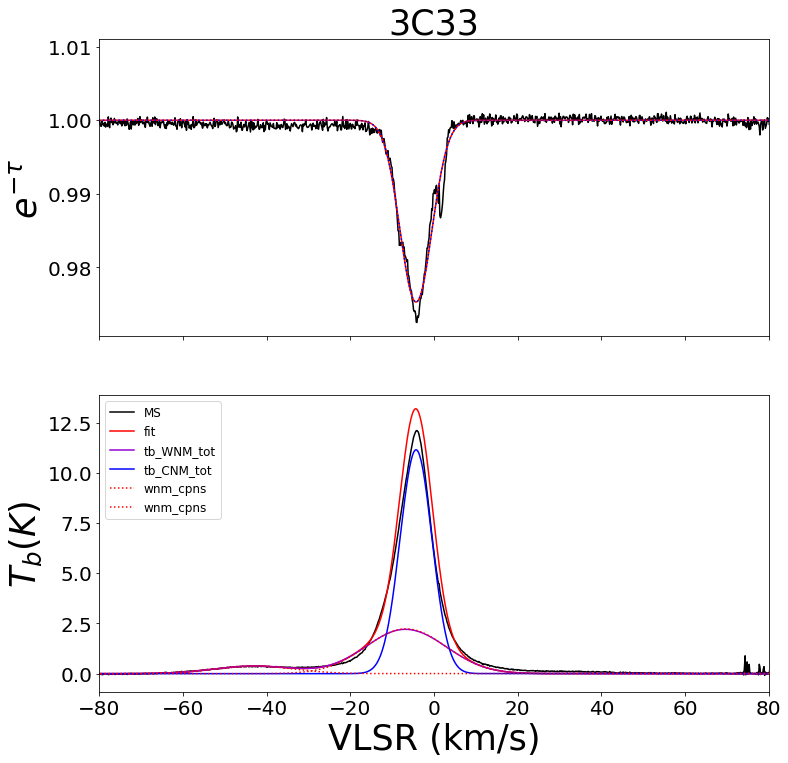



***********
3C18
Number of CNM components:  3
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C18 -8.9 0.669 2.43 39.5599
CNM 3C18 -6.7 0.077 8.62 311.4174
CNM 3C18 -5.7 0.181 3.98 58.046

 (CEN, HGT, WID)
WNM 3C18 -12.6 0.72 53.58
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


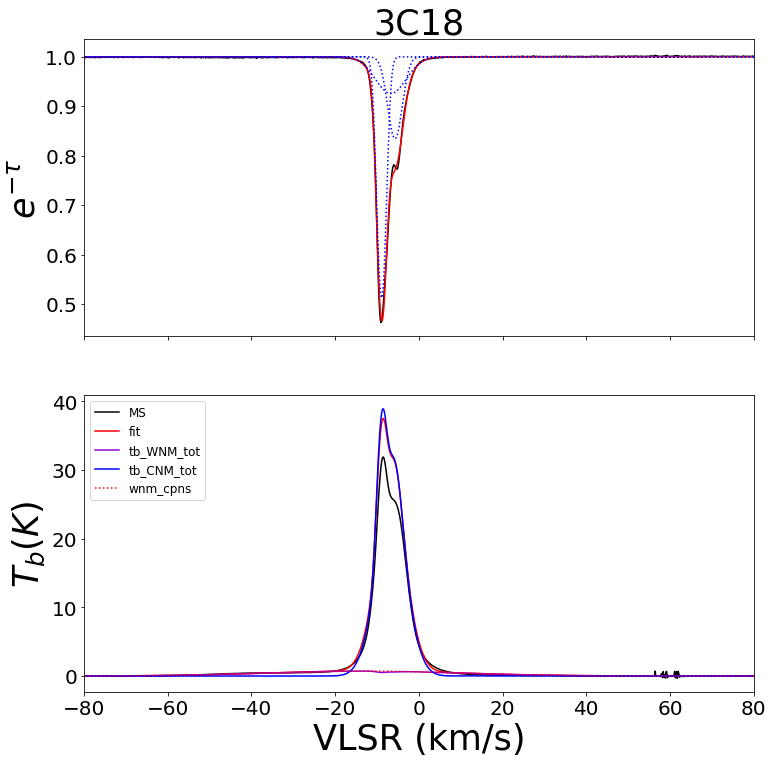



***********
3C272.1
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C272.1 -30.6 0.029 3.81 128.3168
CNM 3C272.1 -9.2 0.009 3.12 178.9802
CNM 3C272.1 -1.5 0.015 3.61 130.2649

 (CEN, HGT, WID)
WNM 3C272.1 -30.1 2.72 13.84
WNM 3C272.1 -7.4 3.2 20.88
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


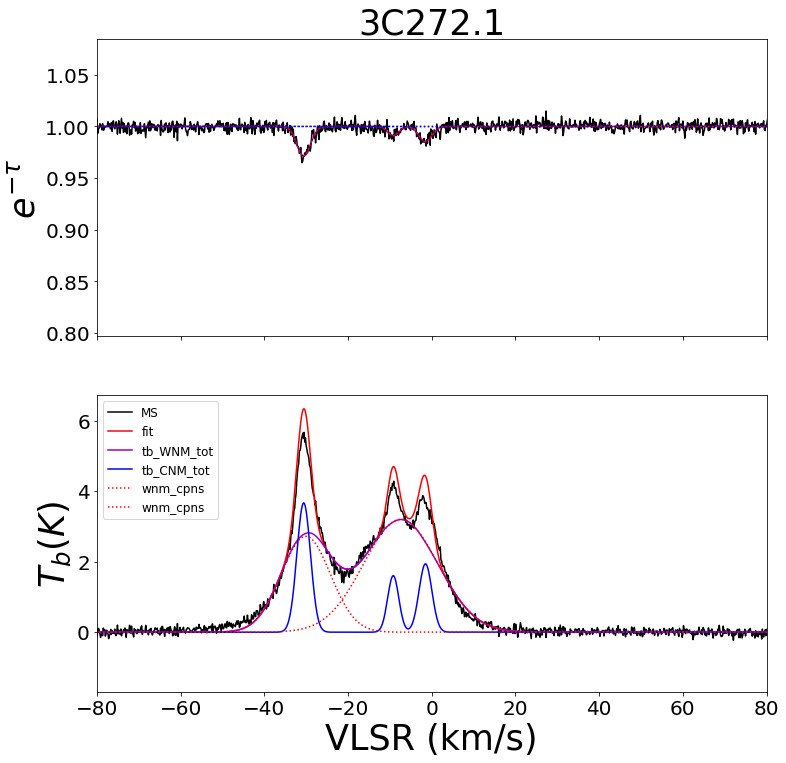



***********
3C141.0
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C141.0 -15.9 0.26 15.41 292.7089
CNM 3C141.0 1.6 0.875 6.19 40.9534

 (CEN, HGT, WID)
WNM 3C141.0 -11.4 3.27 68.55
WNM 3C141.0 0.6 113.44 11.17
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


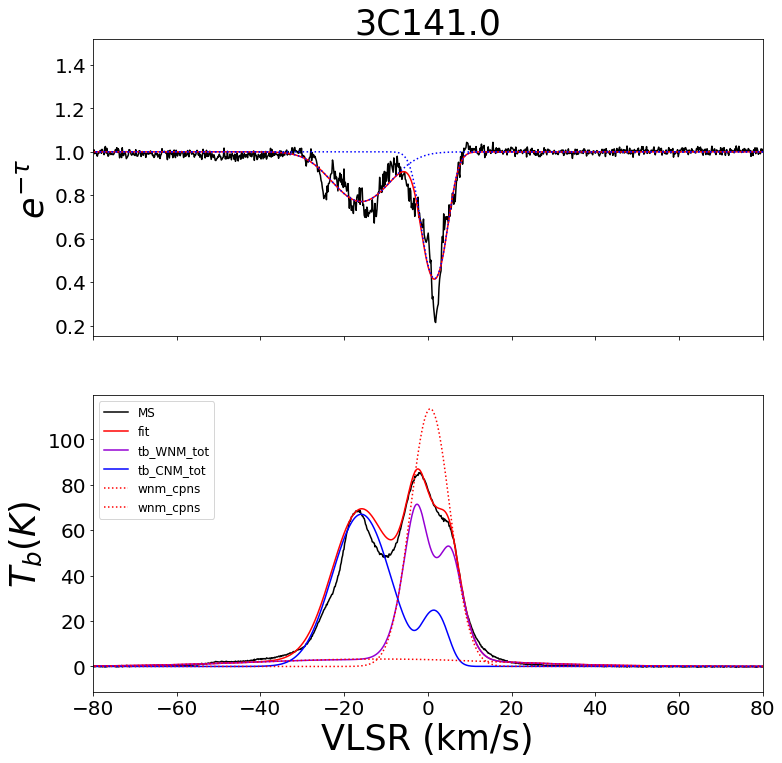



***********
3C142.1
Number of CNM components:  4
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C142.1 -9.2 0.101 3.24 15.7251
CNM 3C142.1 7.0 2.362 3.13 55.5624
CNM 3C142.1 13.4 0.203 4.12 28.6356
CNM 3C142.1 22.4 0.083 3.39 141.9445

 (CEN, HGT, WID)
WNM 3C142.1 -10.6 9.1 8.78
WNM 3C142.1 8.7 39.15 16.13
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


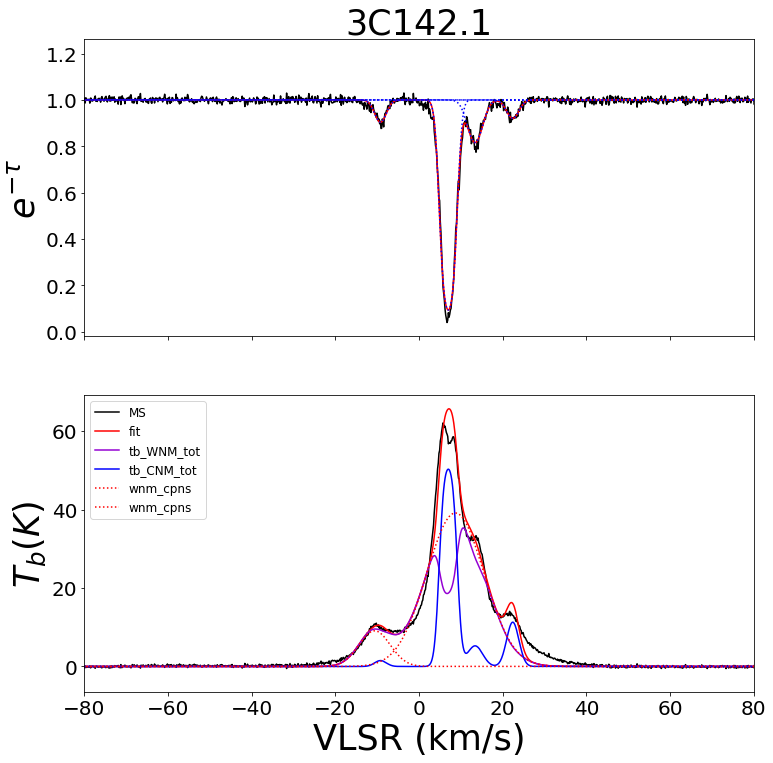



***********
3C33-2
Number of CNM components:  1
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C33-2 -4.2 0.059 9.31 210.7392

 (CEN, HGT, WID)
WNM 3C33-2 -7.2 2.35 22.25
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


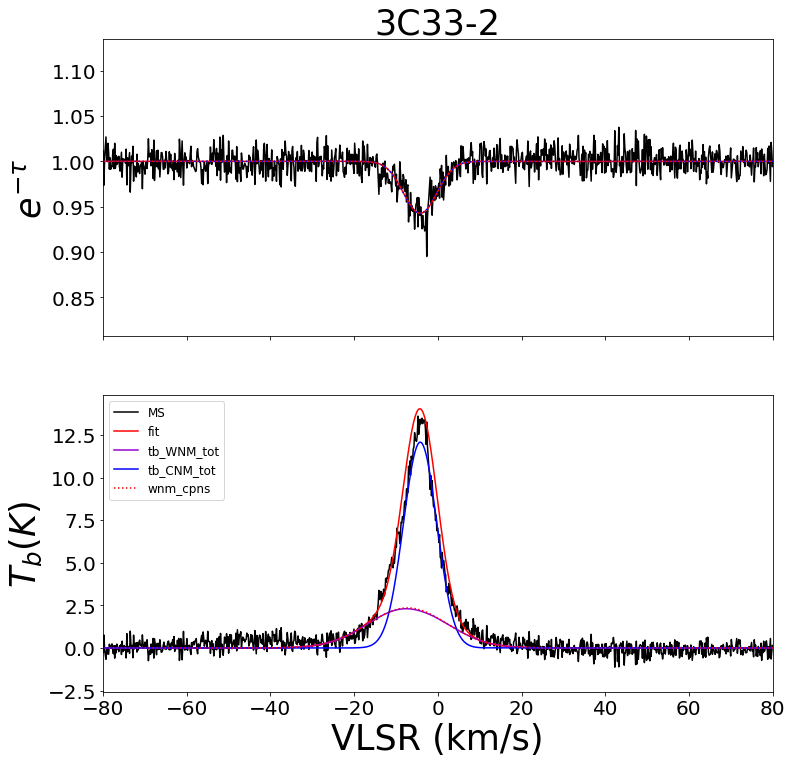



***********
3C75-2
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C75-2 -10.4 0.647 2.33 41.813
CNM 3C75-2 -6.0 0.094 2.34 43.7541
CNM 3C75-2 4.9 0.139 4.41 92.1755

 (CEN, HGT, WID)
WNM 3C75-2 -9.6 10.74 10.46
WNM 3C75-2 5.8 16.98 11.78
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


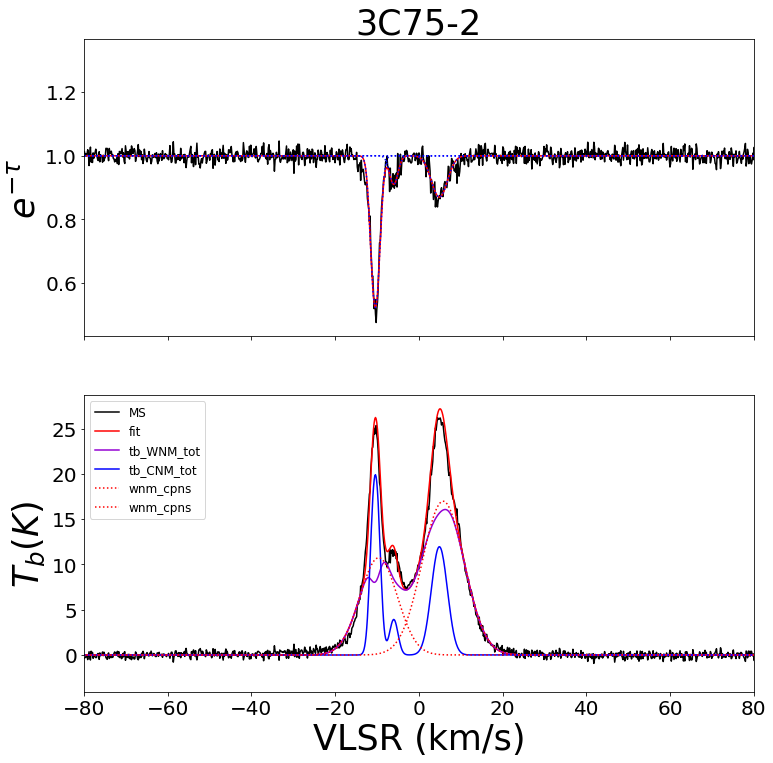



***********
3C75-1
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C75-1 -10.4 0.729 2.06 40.2608
CNM 3C75-1 -6.1 0.082 3.01 24.4279
CNM 3C75-1 5.0 0.127 4.58 99.3526

 (CEN, HGT, WID)
WNM 3C75-1 -9.3 11.48 10.15
WNM 3C75-1 5.8 15.94 11.76
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


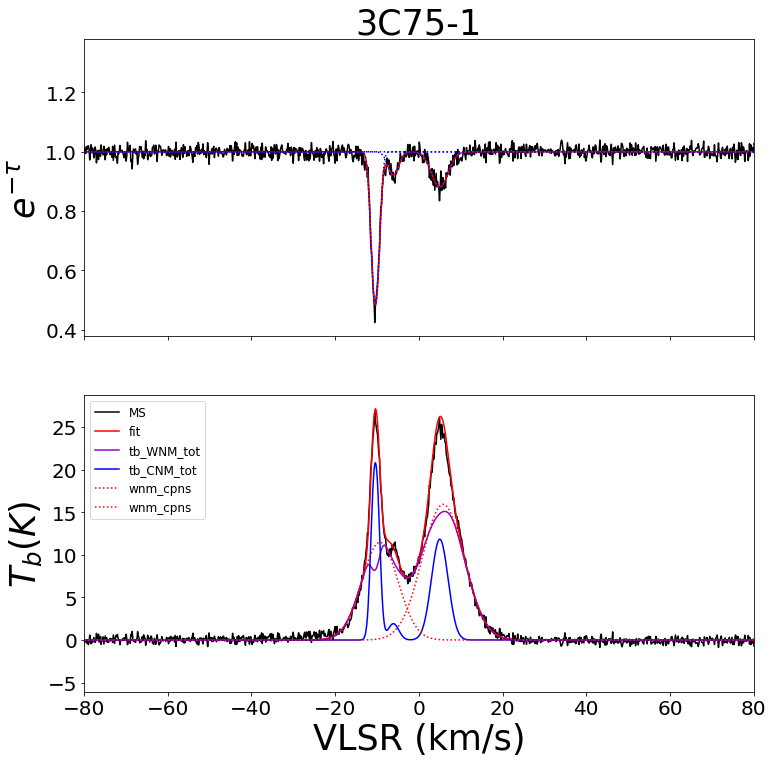



***********
DW0742+10
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM DW0742+10 1.3 3.9 9.03
WNM DW0742+10 8.2 2.63 34.01
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


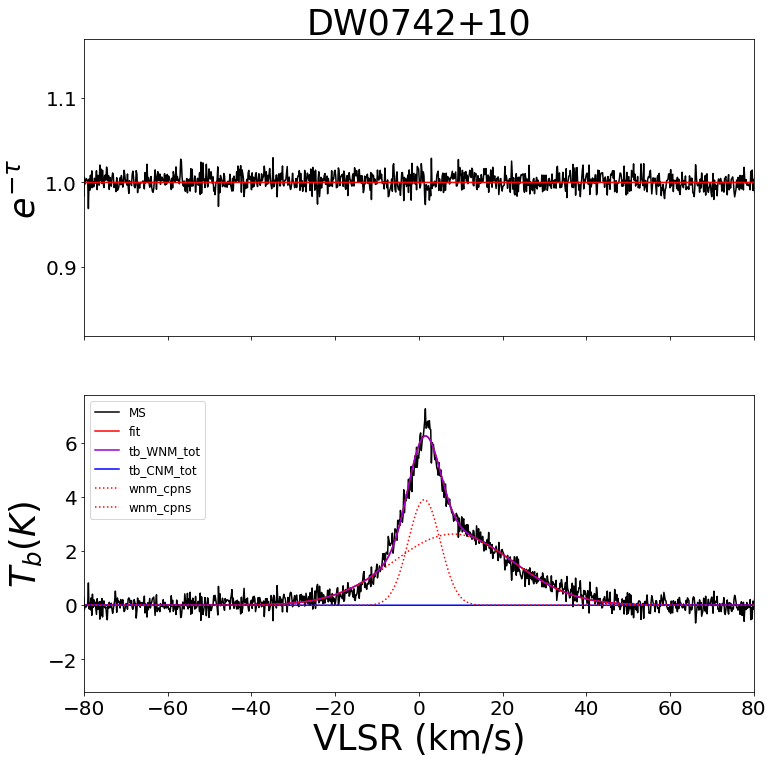



***********
3C33-1
Number of CNM components:  1
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C33-1 -4.6 0.034 9.44 367.1344

 (CEN, HGT, WID)
WNM 3C33-1 -7.1 1.67 26.21
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


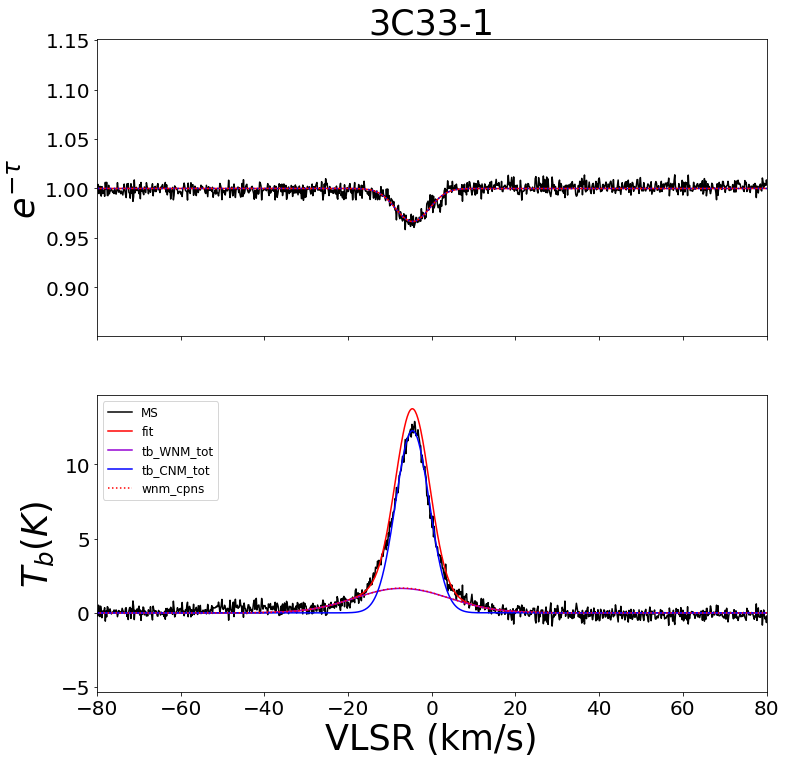



***********
3C79
Number of CNM components:  5
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C79 -6.4 0.342 2.06 11.0871
CNM 3C79 -3.3 0.082 1.18 28.1917
CNM 3C79 1.4 0.139 2.85 64.0887
CNM 3C79 2.2 0.148 14.09 180.5587
CNM 3C79 9.8 0.048 1.14 53.3312

 (CEN, HGT, WID)
WNM 3C79 -3.0 8.08 15.4
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


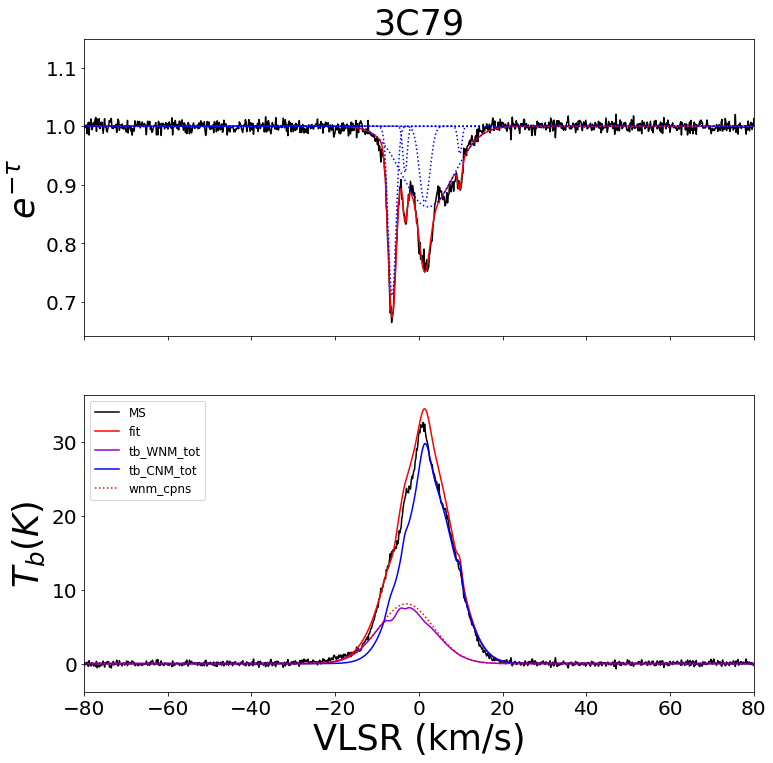



***********
3C78
Number of CNM components:  5
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C78 -8.7 0.023 12.03 599.8756
CNM 3C78 -7.7 0.116 3.07 74.6709
CNM 3C78 4.2 0.153 1.92 57.5043
CNM 3C78 6.8 1.108 2.24 48.311
CNM 3C78 10.7 0.082 4.26 67.6225

 (CEN, HGT, WID)
WNM 3C78 8.1 19.04 11.47
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


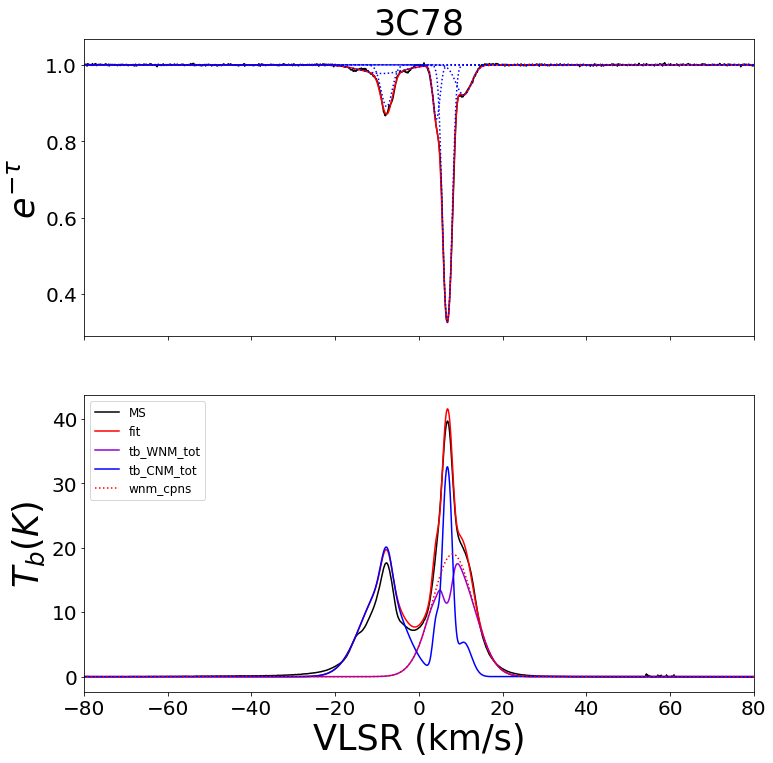



***********
3C98-1
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C98-1 -1.2 0.081 3.23 29.9126
CNM 3C98-1 9.4 0.209 1.47 49.0656
CNM 3C98-1 9.7 0.368 6.07 132.0012
CNM 3C98-1 22.8 0.028 5.4 262.8894

 (CEN, HGT, WID)
WNM 3C98-1 6.0 16.65 13.51
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


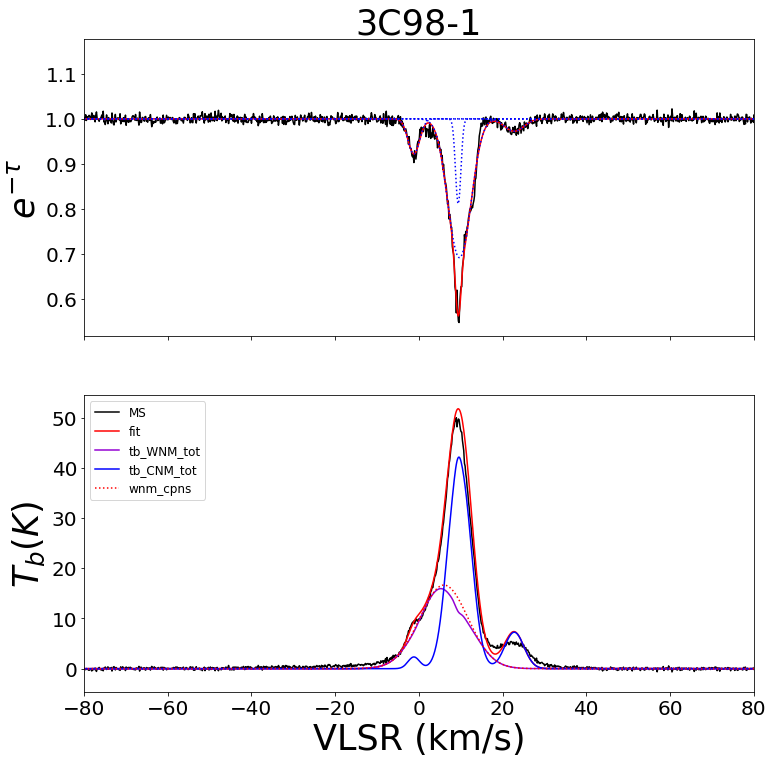



***********
3C75
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C75 -10.4 0.682 2.32 41.8324
CNM 3C75 -5.8 0.095 2.74 46.9208
CNM 3C75 5.3 0.113 5.19 122.1235

 (CEN, HGT, WID)
WNM 3C75 -10.0 9.56 9.79
WNM 3C75 5.7 14.09 13.05
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


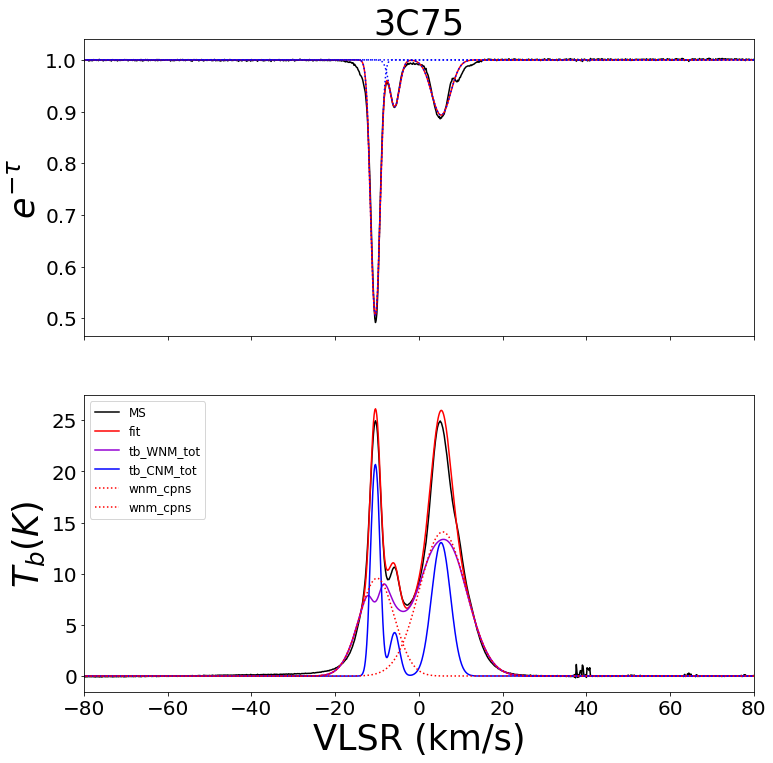



***********
4C13.65
Number of CNM components:  3
Number of WNM components:  4

 CEN, HGT, WID, Tspin
CNM 4C13.65 -12.8 0.022 5.57 76.8717
CNM 4C13.65 1.4 0.6 2.04 36.7249
CNM 4C13.65 3.4 0.344 2.57 41.5202

 (CEN, HGT, WID)
WNM 4C13.65 1.9 10.04 7.06
WNM 4C13.65 9.6 2.66 4.73
WNM 4C13.65 12.8 8.53 35.42
WNM 4C13.65 20.0 1.88 5.57
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


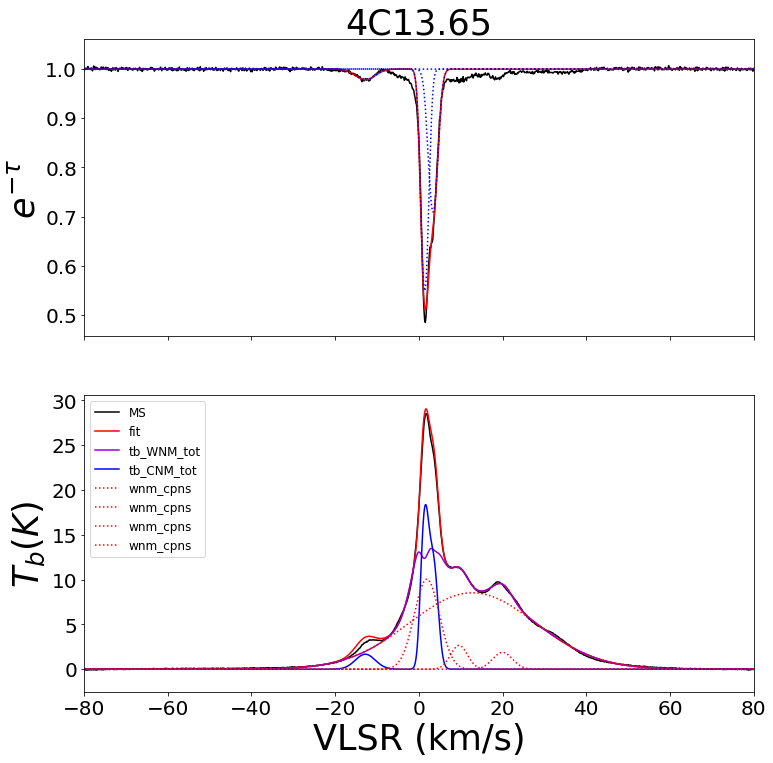



***********
3C133
Number of CNM components:  5
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C133 -29.5 0.06 8.45 258.5831
CNM 3C133 -27.6 0.064 2.84 29.4811
CNM 3C133 -0.2 0.262 6.17 77.7026
CNM 3C133 3.7 0.891 2.77 50.5762
CNM 3C133 8.0 1.532 2.51 44.0369

 (CEN, HGT, WID)
WNM 3C133 -14.7 9.06 46.06
WNM 3C133 4.3 45.62 12.41
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


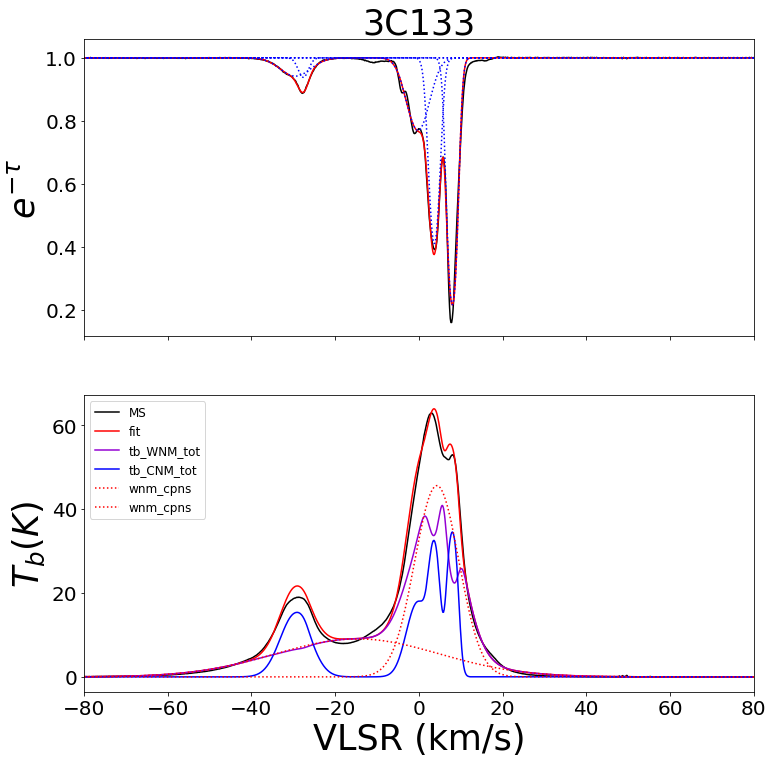



***********
3C98-2
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C98-2 -1.5 0.09 3.16 72.1498
CNM 3C98-2 9.5 0.203 1.39 29.9478
CNM 3C98-2 9.6 0.452 4.62 115.1018
CNM 3C98-2 22.5 0.035 4.56 202.6307

 (CEN, HGT, WID)
WNM 3C98-2 7.3 20.18 13.21
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


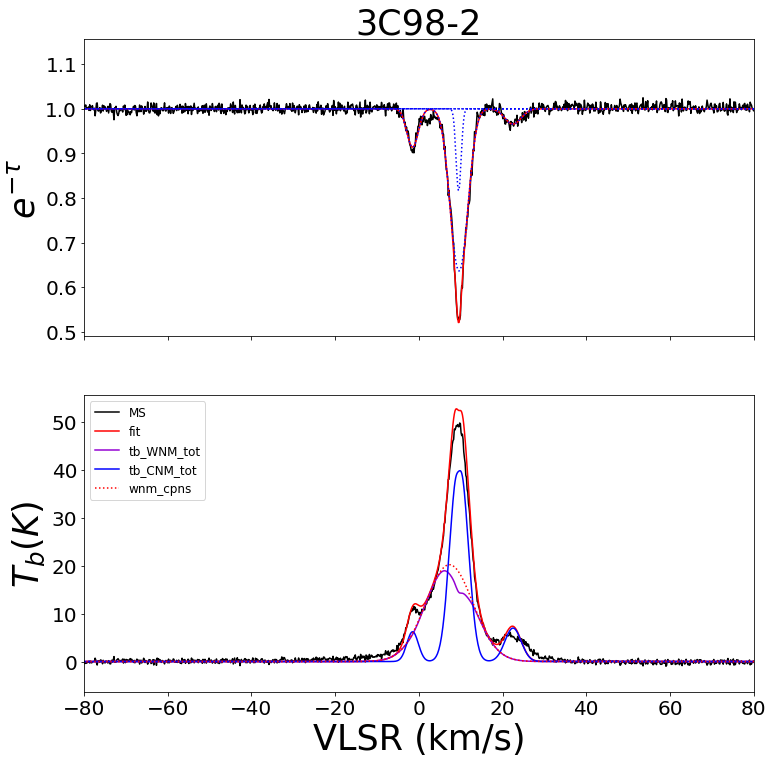



***********
3C131
Number of CNM components:  2
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C131 -2.3 0.321 6.95 90.1881
CNM 3C131 5.3 2.152 4.24 50.7709

 (CEN, HGT, WID)
WNM 3C131 -40.1 10.77 5.74
WNM 3C131 -19.1 9.21 43.93
WNM 3C131 1.5 25.06 16.8
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


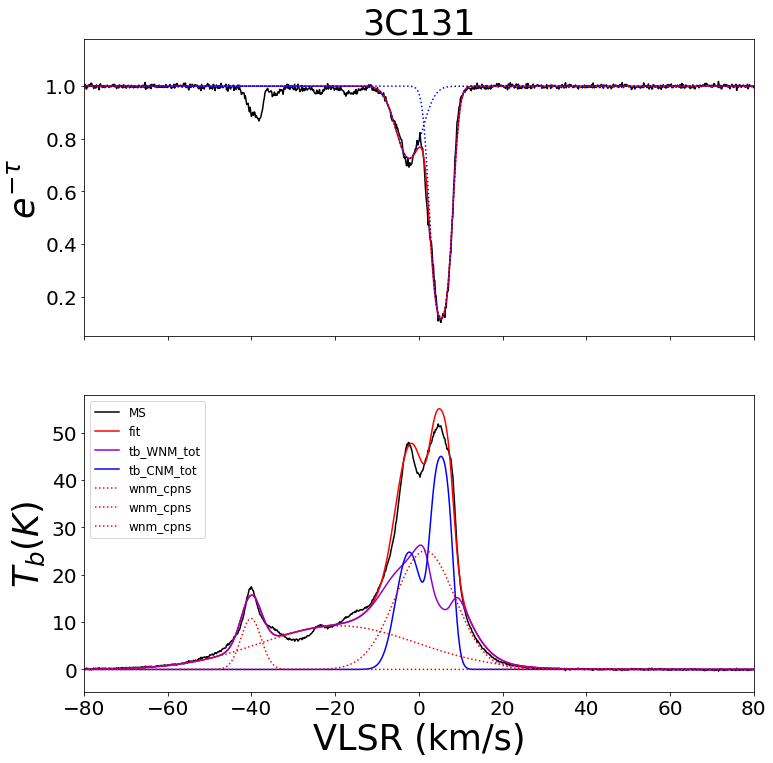



***********
3C245
Number of CNM components:  1
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C245 -8.6 0.009 5.63 632.3893

 (CEN, HGT, WID)
WNM 3C245 -10.4 3.71 21.46
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


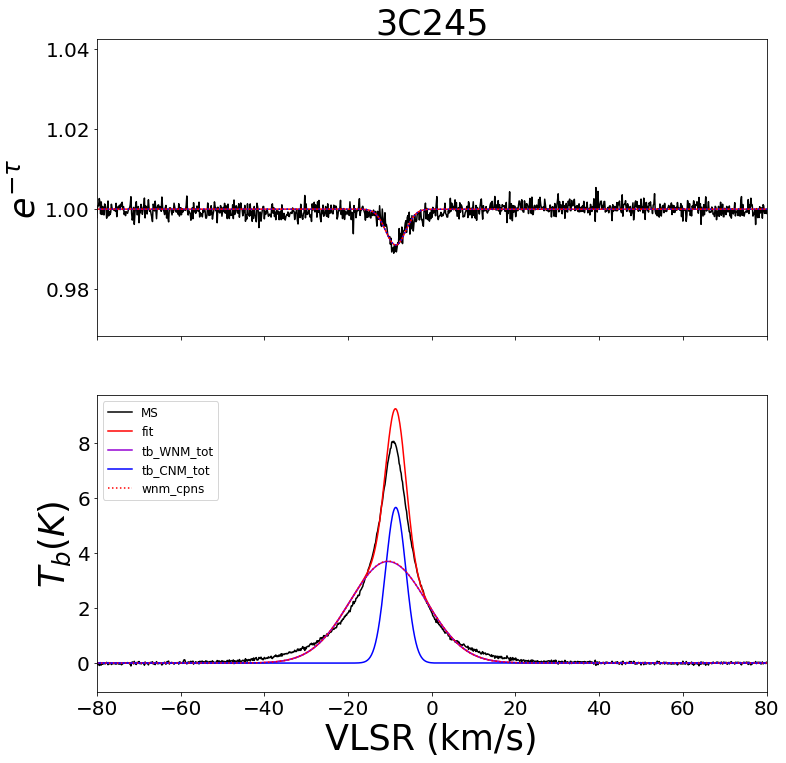



***********
3C315
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C315 -4.2 0.784 2.15 50.851
CNM 3C315 1.6 0.146 4.41 72.787

 (CEN, HGT, WID)
WNM 3C315 -4.2 2.04 26.13
WNM 3C315 -2.8 12.49 6.26
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


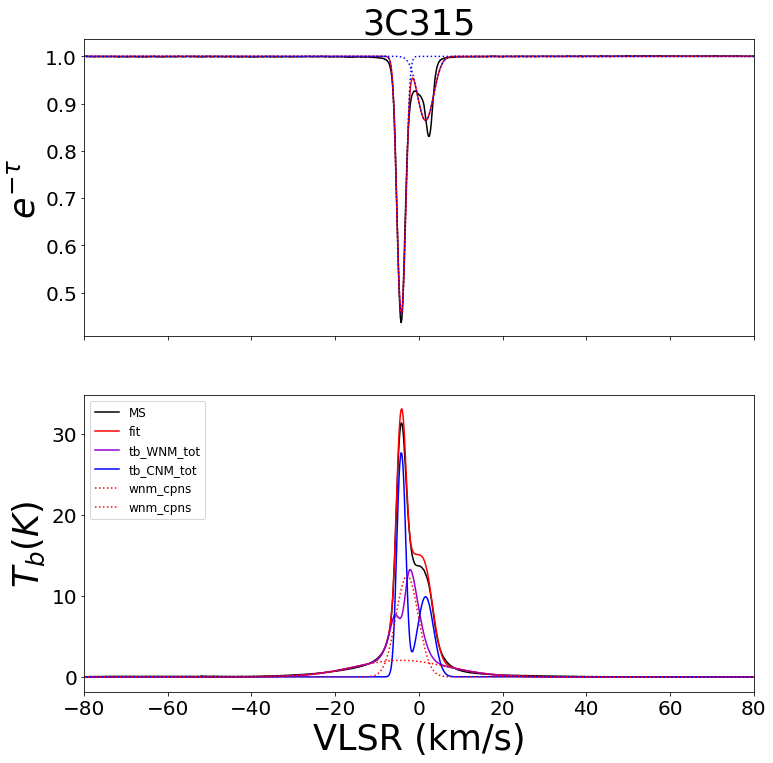



***********
3C109
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C109 5.0 0.381 3.48 81.4378
CNM 3C109 9.3 1.979 4.35 83.0609
CNM 3C109 13.5 0.344 2.35 109.9863

 (CEN, HGT, WID)
WNM 3C109 0.8 10.31 4.53
WNM 3C109 2.4 8.52 26.59
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


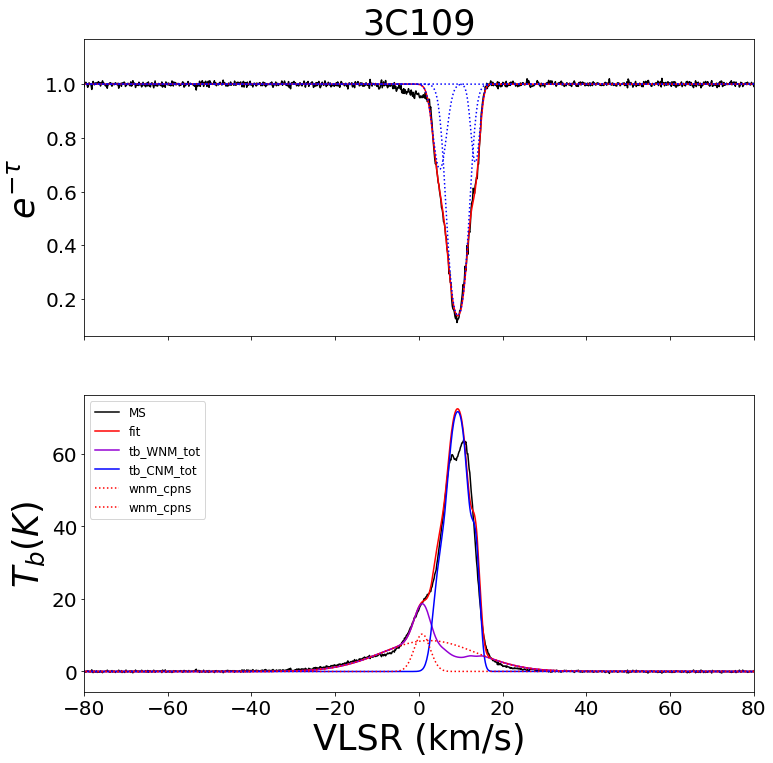



***********
3C234
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C234 -17.1 1.3 51.37
WNM 3C234 0.3 1.29 12.39
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


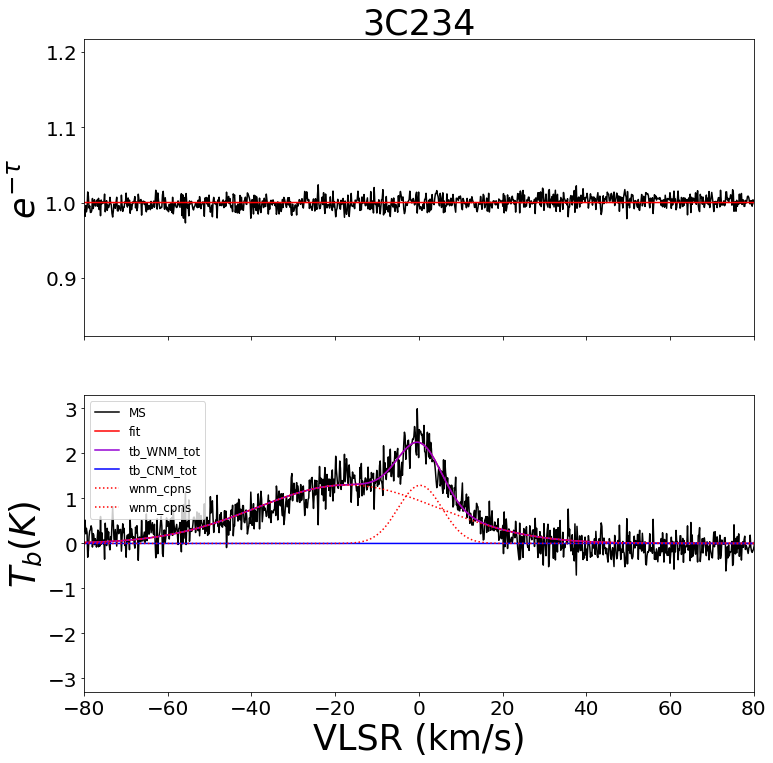



***********
3C236
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C236 -44.1 0.31 17.62
WNM 3C236 -10.1 1.53 36.79
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


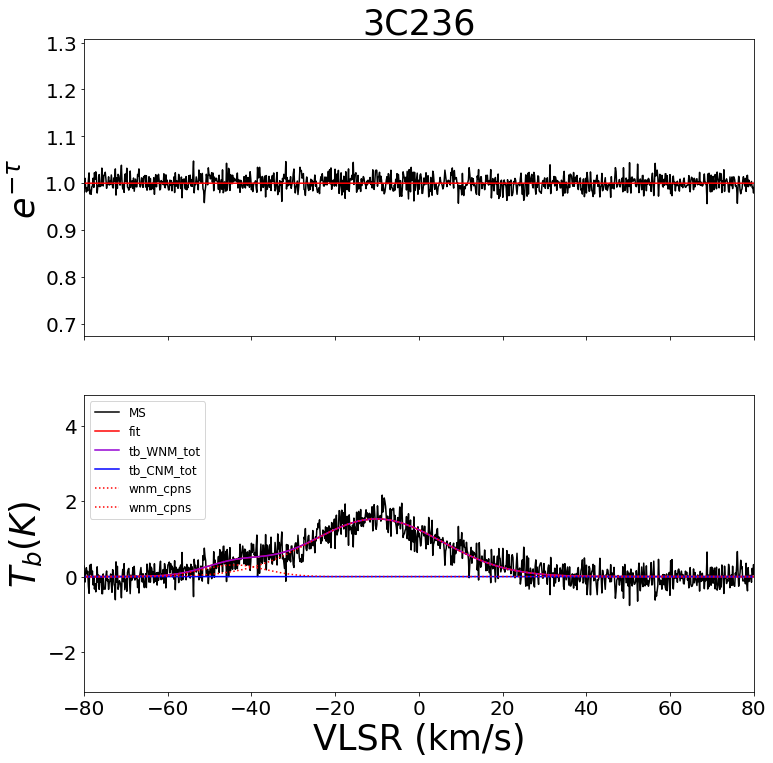



***********
3C310
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C310 -3.7 0.62 1.75 44.8338
CNM 3C310 0.6 0.061 5.11 63.1929

 (CEN, HGT, WID)
WNM 3C310 -12.1 1.25 33.81
WNM 3C310 -1.4 9.54 9.54
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


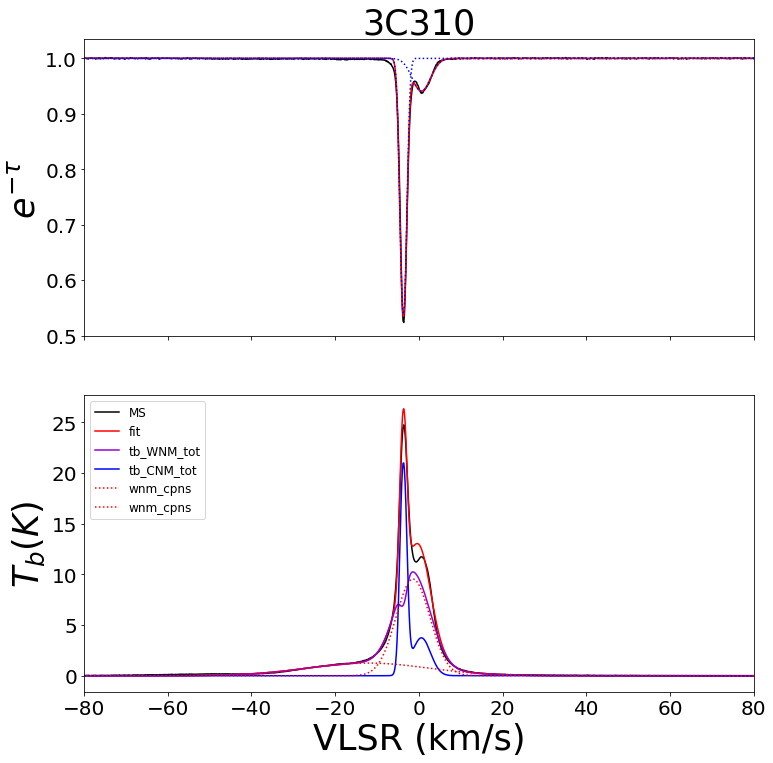



***********
3C154
Number of CNM components:  6
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C154 -23.7 0.068 4.35 208.9991
CNM 3C154 -2.9 0.709 4.45 56.2123
CNM 3C154 -2.1 0.292 1.32 28.8044
CNM 3C154 1.8 0.919 2.63 58.8176
CNM 3C154 5.0 0.479 3.47 59.9081
CNM 3C154 10.6 0.413 2.12 37.5134

 (CEN, HGT, WID)
WNM 3C154 1.4 75.24 18.23
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


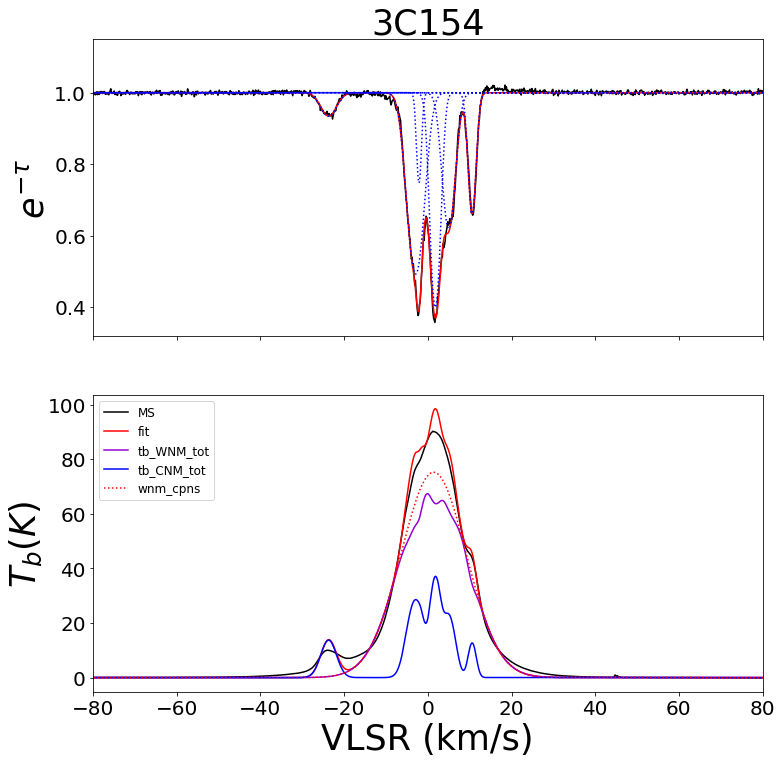



***********
3C105
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C105 -2.0 0.057 4.37 100.9354
CNM 3C105 8.3 2.103 1.81 33.3549
CNM 3C105 8.4 0.169 9.47 184.9314
CNM 3C105 10.5 2.883 1.97 39.9513

 (CEN, HGT, WID)
WNM 3C105 6.5 6.85 24.41
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


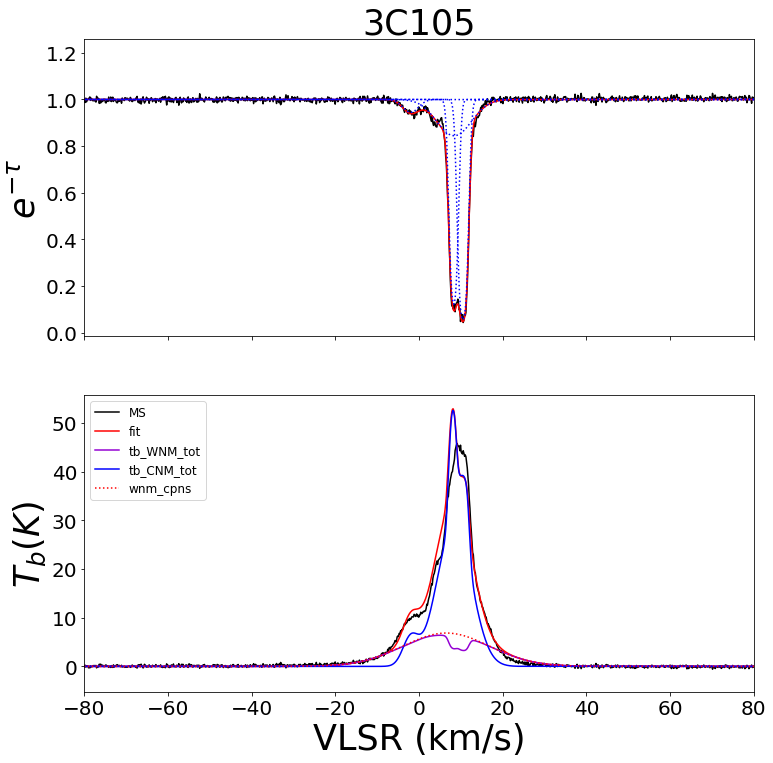



***********
3C228.0
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C228.0 -5.1 0.082 2.86 85.6697
CNM 3C228.0 -1.4 0.027 2.13 67.1398

 (CEN, HGT, WID)
WNM 3C228.0 -28.5 0.99 21.38
WNM 3C228.0 -3.9 6.4 14.68
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


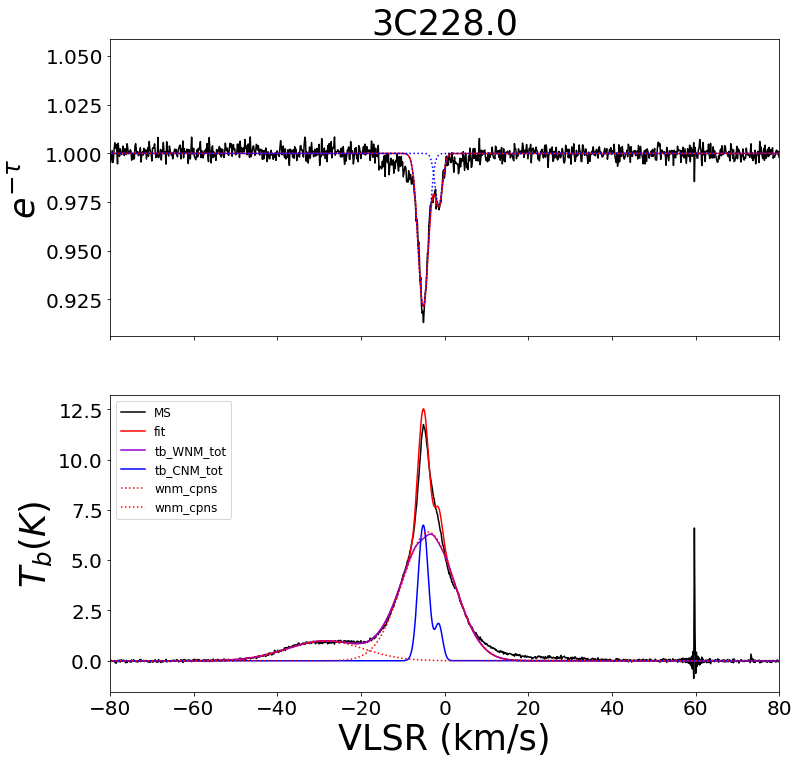



***********
4C22.12
Number of CNM components:  5
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 4C22.12 -2.2 6.994 1.26 40.254
CNM 4C22.12 4.4 7.911 0.83 68.8334
CNM 4C22.12 5.1 1.756 11.63 94.1299
CNM 4C22.12 7.5 4.067 0.9 78.2829
CNM 4C22.12 15.8 0.84 3.97 39.5358

 (CEN, HGT, WID)
WNM 4C22.12 6.2 82.17 19.77
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


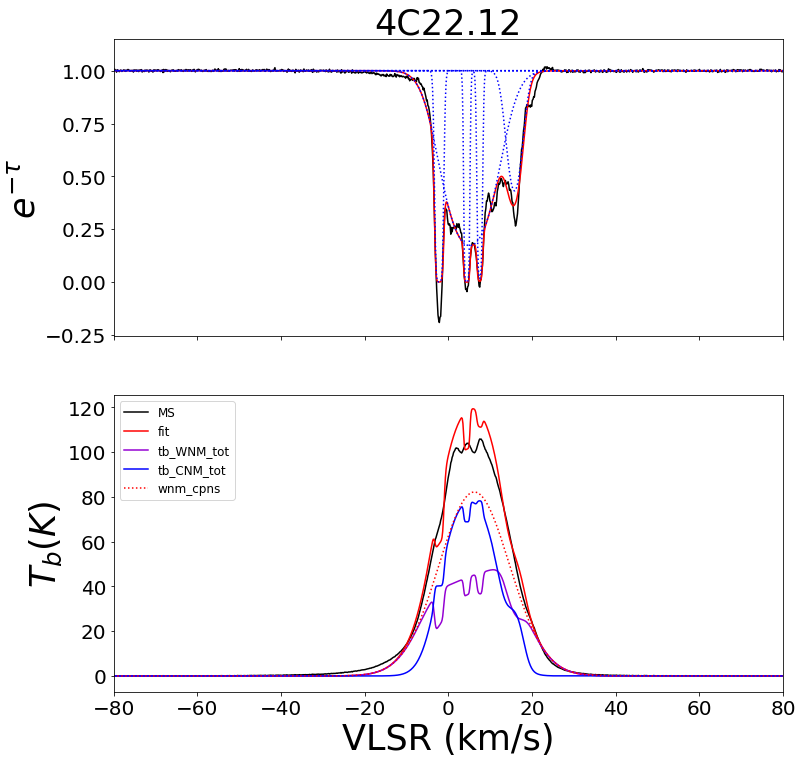



***********
NRAO140
Number of CNM components:  1
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM NRAO140 6.8 7.011 3.66 30.6095

 (CEN, HGT, WID)
WNM NRAO140 -5.4 4.06 36.5
WNM NRAO140 5.6 134.13 4.16
WNM NRAO140 6.2 38.87 10.01
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


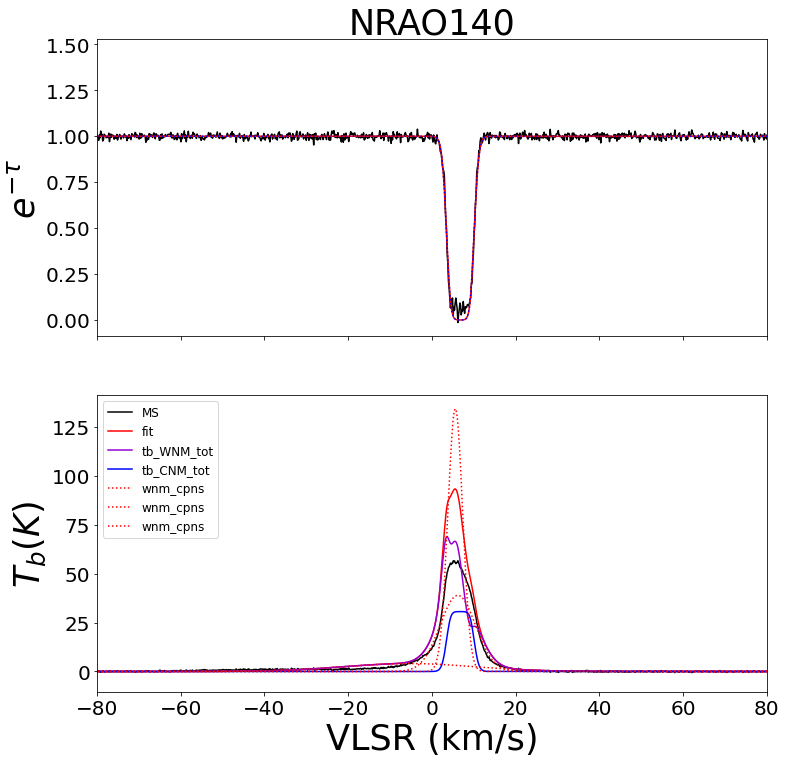



***********
3C318
Number of CNM components:  2
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C318 -6.0 0.482 1.77 39.8355
CNM 3C318 -5.0 0.3 3.36 70.1414

 (CEN, HGT, WID)
WNM 3C318 -56.0 0.32 19.18
WNM 3C318 -11.2 0.93 42.74
WNM 3C318 -3.4 11.64 9.32
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


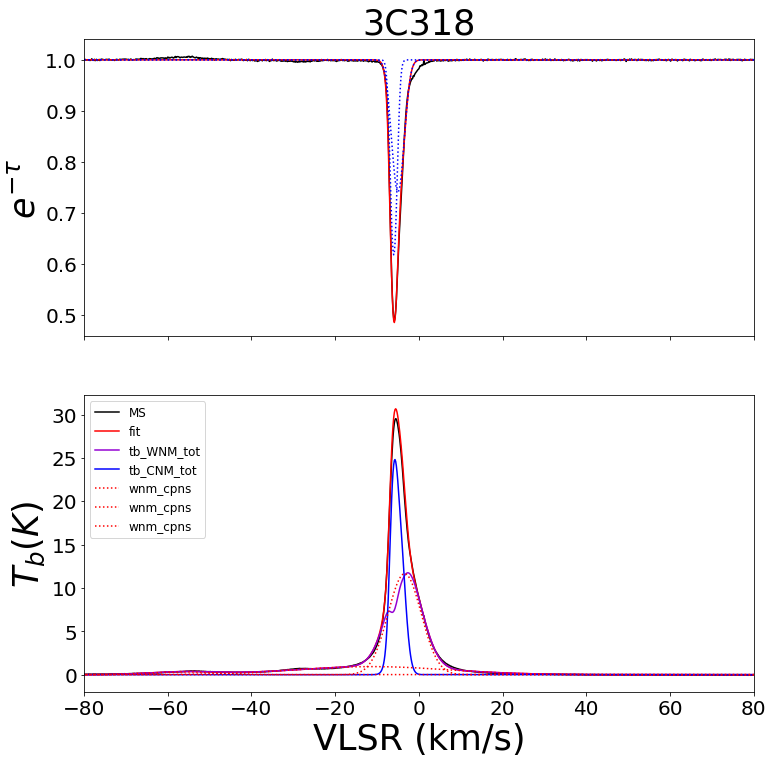



***********
3C353
Number of CNM components:  5
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C353 -8.4 0.006 4.19 433.6131
CNM 3C353 0.0 1.209 2.8 42.3111
CNM 3C353 1.4 0.195 5.84 186.7392
CNM 3C353 2.4 0.859 1.69 30.8355
CNM 3C353 11.9 0.04 3.01 60.2482

 (CEN, HGT, WID)
WNM 3C353 6.0 7.33 26.88
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


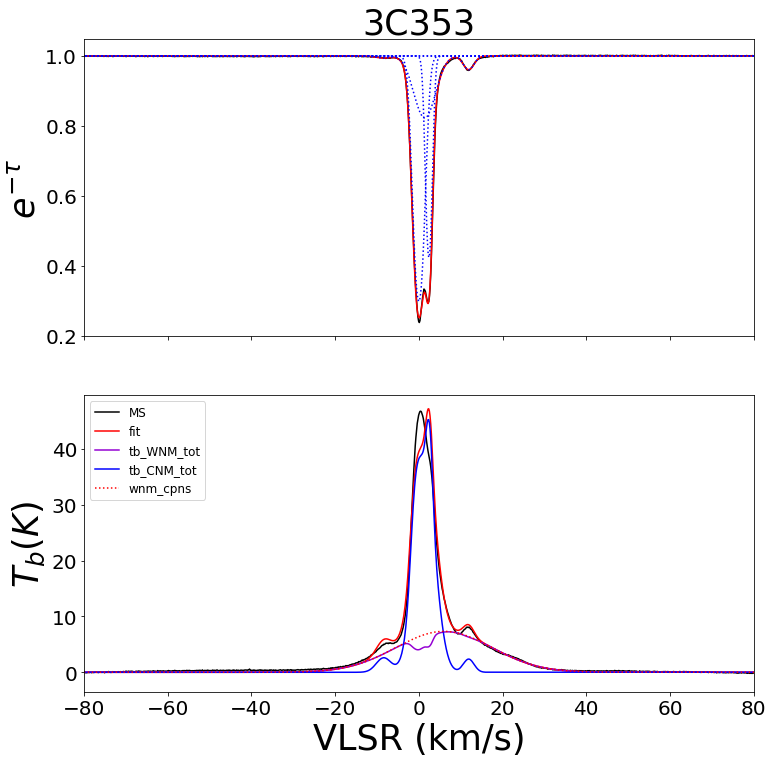



***********
4C32.44
Number of CNM components:  2
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 4C32.44 -16.9 0.02 2.55 152.3504
CNM 4C32.44 -4.6 0.007 1.41 235.6009

 (CEN, HGT, WID)
WNM 4C32.44 -10.2 1.53 30.49
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


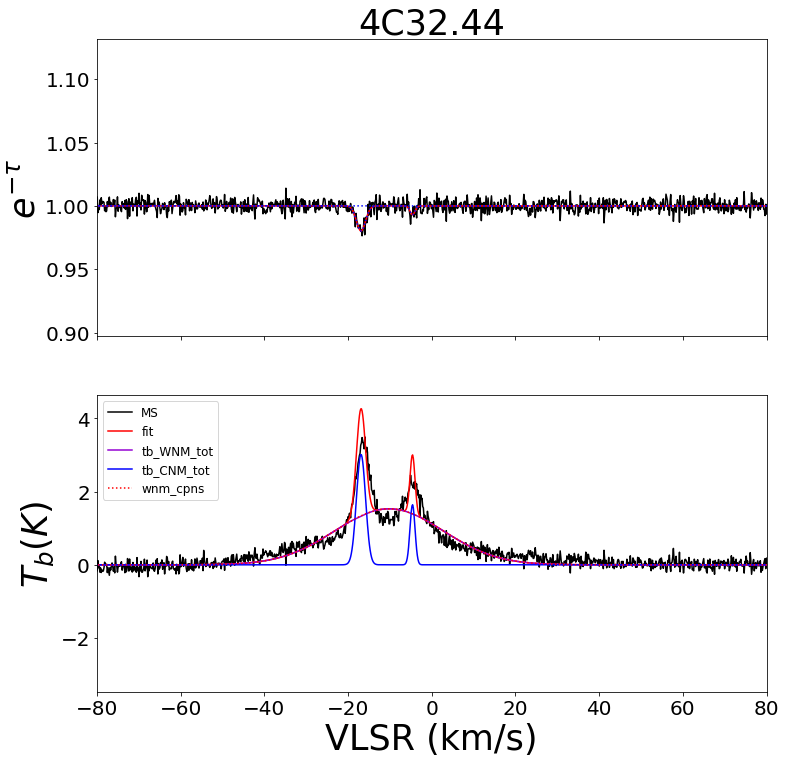



***********
T0526+24
Number of CNM components:  4
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM T0526+24 -7.6 1.08 6.22 53.1911
CNM T0526+24 2.5 2.809 1.08 38.1028
CNM T0526+24 5.9 1.413 7.86 65.3314
CNM T0526+24 7.1 39.128 1.2 62.3808

 (CEN, HGT, WID)
WNM T0526+24 -27.4 2.5 1.83
WNM T0526+24 -21.2 14.45 18.94
WNM T0526+24 0.2 55.0 19.5
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


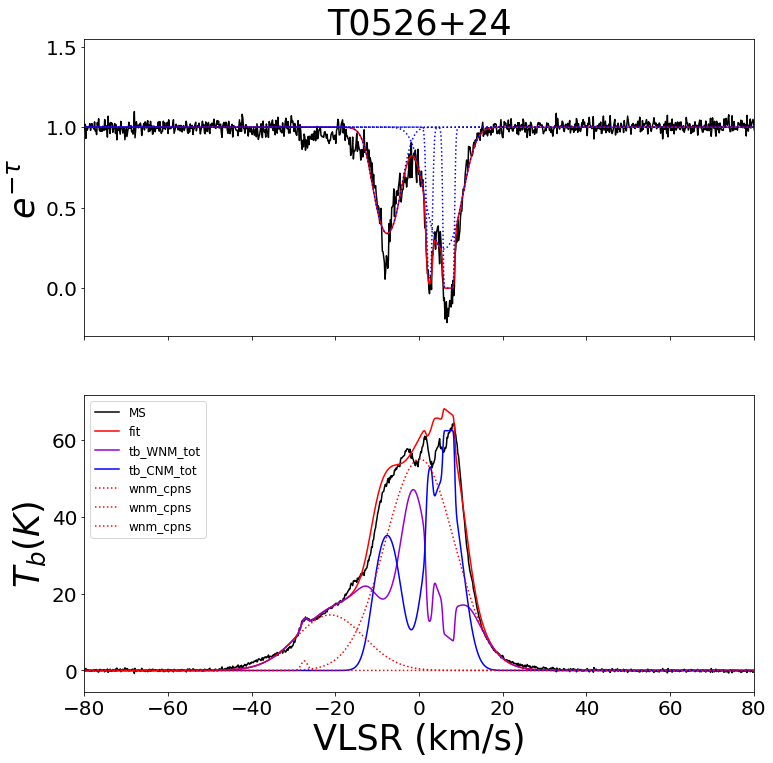



***********
3C454.3
Number of CNM components:  7
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C454.3 -35.4 0.016 3.36 95.9909
CNM 3C454.3 -30.4 0.048 2.0 20.4194
CNM 3C454.3 -16.8 0.015 5.51 205.7754
CNM 3C454.3 -10.1 0.298 2.65 48.9328
CNM 3C454.3 -2.0 0.091 3.69 104.4364
CNM 3C454.3 0.7 0.079 1.81 58.9362
CNM 3C454.3 3.4 0.022 4.2 69.2738

 (CEN, HGT, WID)
WNM 3C454.3 -31.2 3.02 36.89
WNM 3C454.3 -1.1 9.02 14.96
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


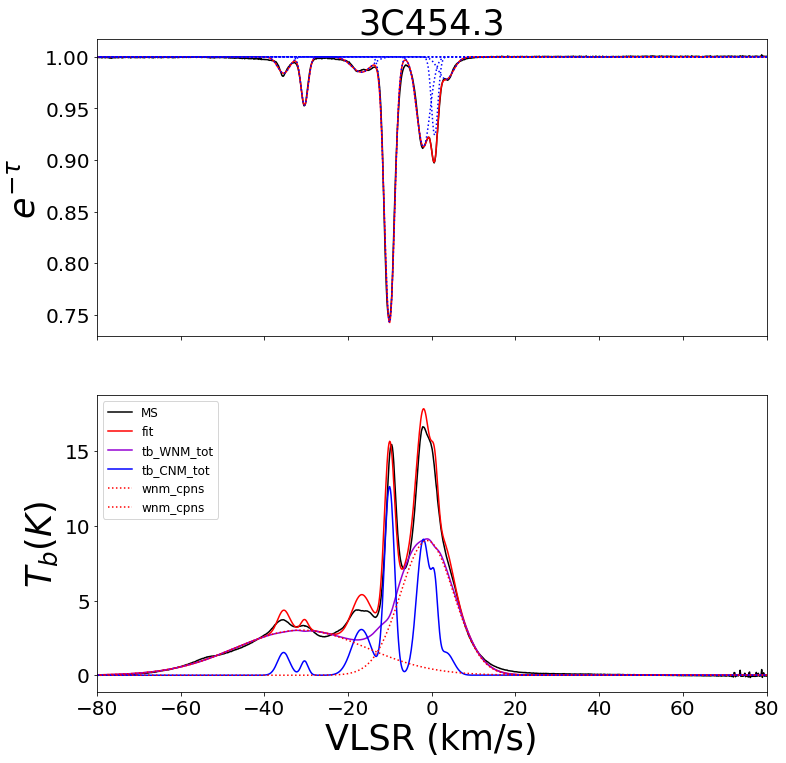



***********
3C225b
Number of CNM components:  5
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C225b -40.6 0.033 2.07 32.5355
CNM 3C225b -37.9 0.047 2.52 79.1235
CNM 3C225b -28.0 0.027 4.78 68.3866
CNM 3C225b -5.6 0.013 6.82 211.5752
CNM 3C225b 3.6 0.745 1.25 20.293

 (CEN, HGT, WID)
WNM 3C225b -29.7 1.79 20.22
WNM 3C225b -2.8 5.73 15.4
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


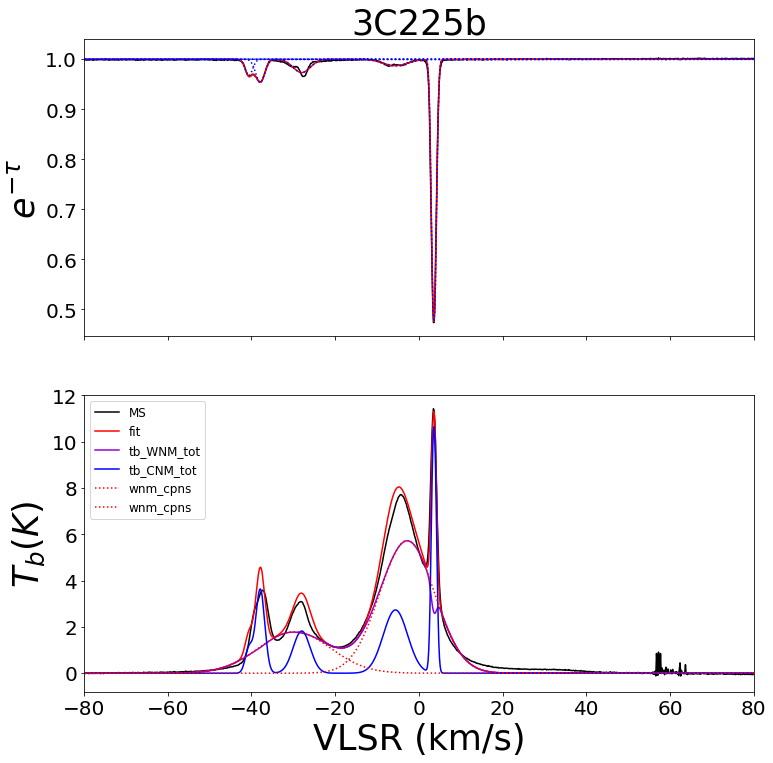



***********
P0820+22
Number of CNM components:  0
Number of WNM components:  4

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM P0820+22 -37.2 1.09 21.58
WNM P0820+22 -7.9 3.18 15.38
WNM P0820+22 7.2 1.11 63.39
WNM P0820+22 9.8 6.75 11.03
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


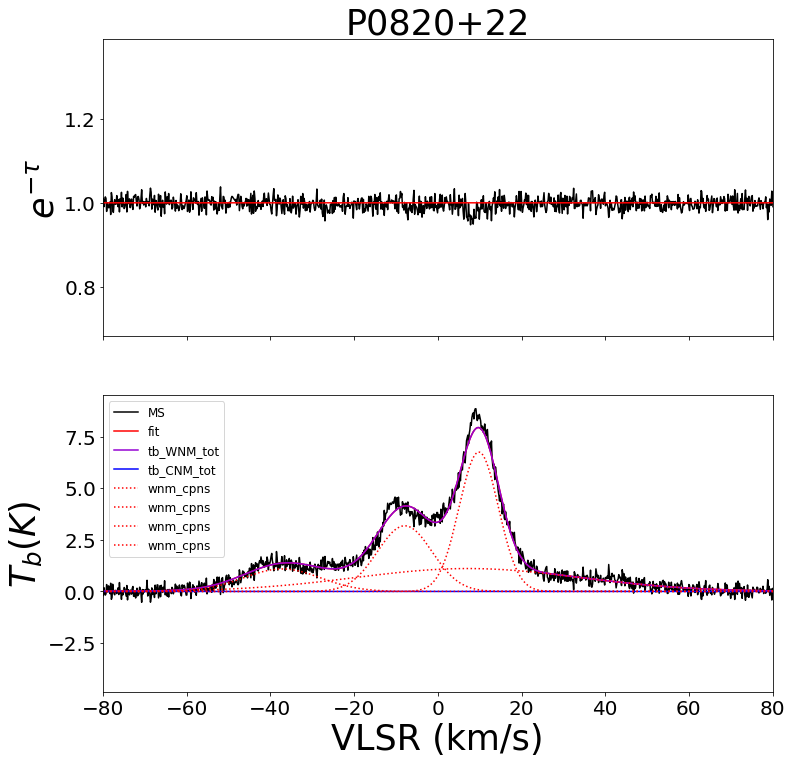



***********
3C333
Number of CNM components:  1
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C333 0.9 0.993 2.11 31.1371

 (CEN, HGT, WID)
WNM 3C333 -37.8 0.72 27.06
WNM 3C333 -0.6 3.84 24.47
WNM 3C333 0.9 16.93 5.4
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


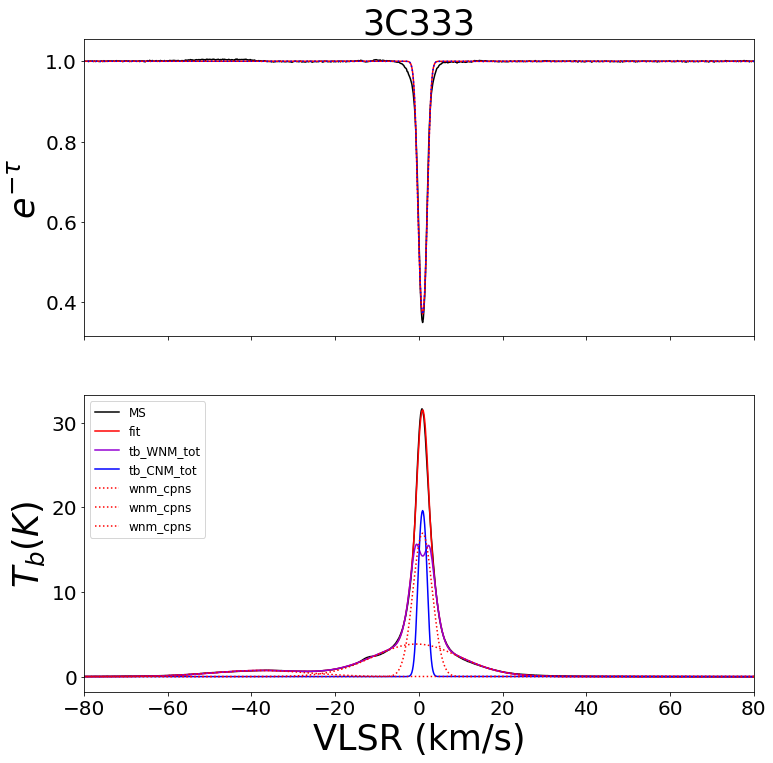



***********
3C192
Number of CNM components:  1
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C192 8.0 0.068 4.3 100.4347

 (CEN, HGT, WID)
WNM 3C192 -3.0 2.54 34.85
WNM 3C192 7.5 7.54 12.13
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


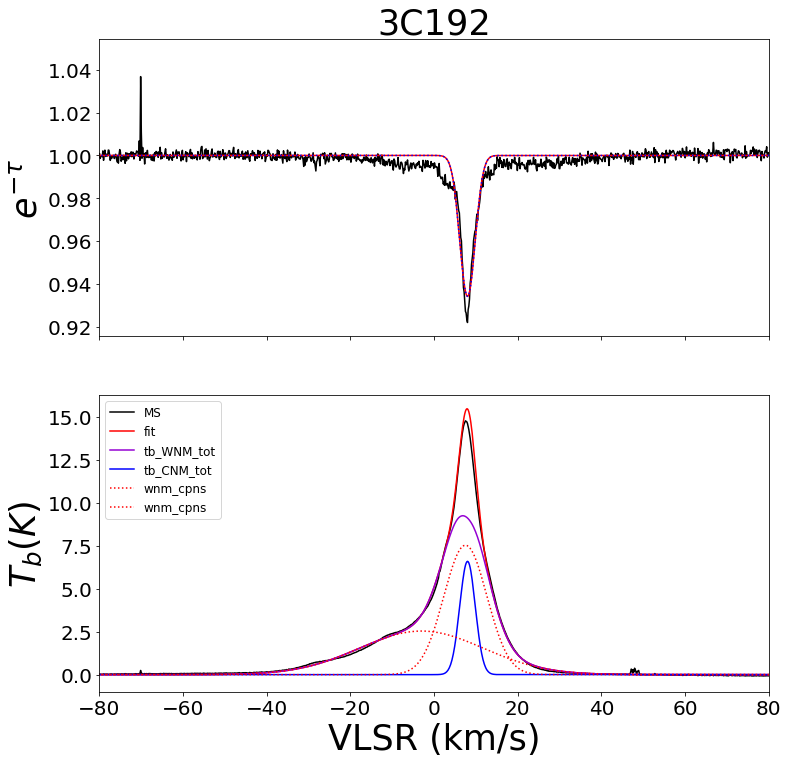



***********
3C138
Number of CNM components:  6
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C138 -21.5 0.038 3.45 129.7345
CNM 3C138 -0.5 0.247 2.86 63.5298
CNM 3C138 1.6 0.176 1.84 62.8049
CNM 3C138 1.8 0.06 14.64 440.9668
CNM 3C138 6.4 1.046 2.3 45.9735
CNM 3C138 9.1 0.406 2.81 54.6857

 (CEN, HGT, WID)
WNM 3C138 -8.6 5.2 47.38
WNM 3C138 6.8 20.17 11.11
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


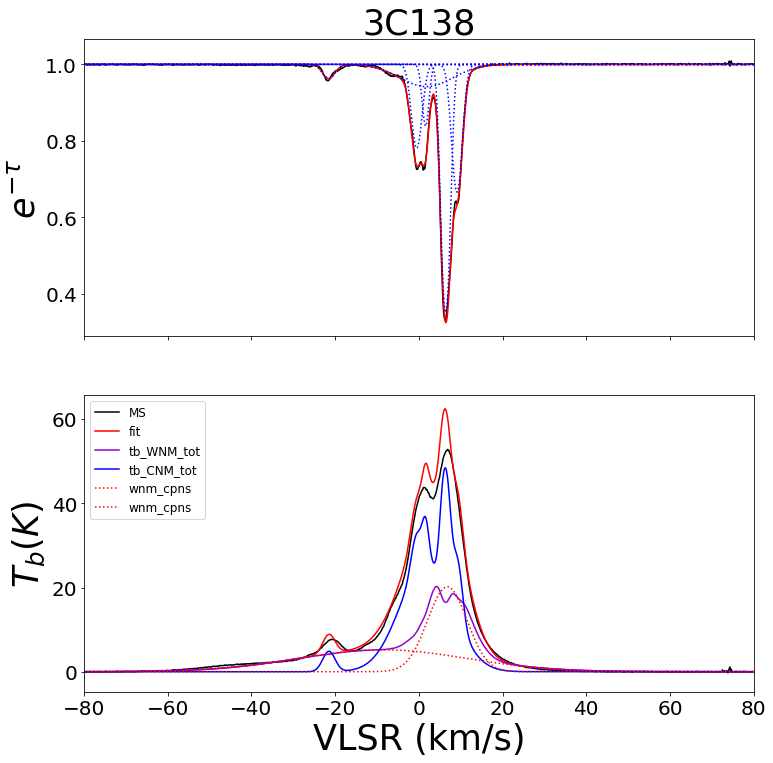



***********
3C273
Number of CNM components:  4
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C273 -6.3 0.018 2.37 78.0887
CNM 3C273 -5.5 0.006 6.38 825.3052
CNM 3C273 24.2 0.002 2.0 248.933
CNM 3C273 31.8 0.003 2.85 165.8724

 (CEN, HGT, WID)
WNM 3C273 -13.9 1.72 35.03
WNM 3C273 26.1 0.64 20.99
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


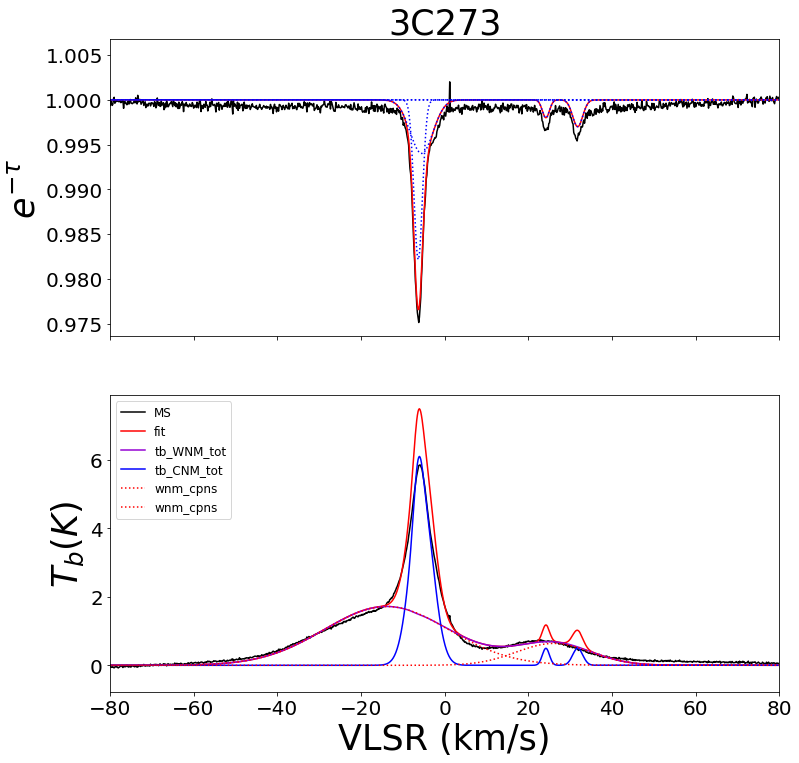



***********
3C267.0
Number of CNM components:  0
Number of WNM components:  3

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C267.0 -28.8 2.99 9.37
WNM 3C267.0 -21.3 1.94 37.86
WNM 3C267.0 -2.5 1.48 12.05
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


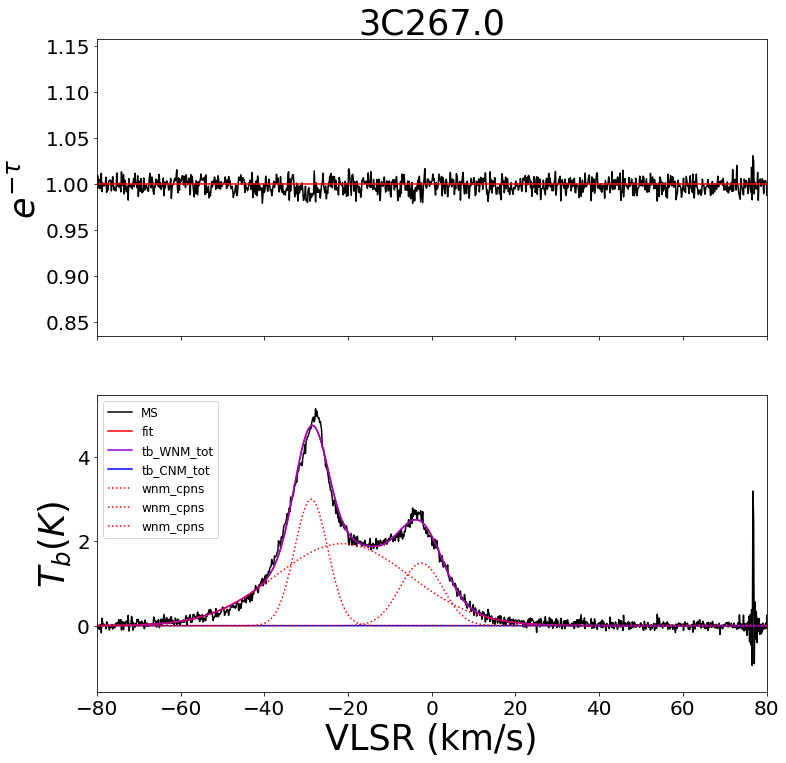



***********
P0428+20
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM P0428+20 3.2 1.132 3.42 32.7744
CNM P0428+20 9.2 1.318 3.7 37.9008
CNM P0428+20 10.6 2.346 1.5 26.814

 (CEN, HGT, WID)
WNM P0428+20 -5.4 4.27 40.1
WNM P0428+20 5.3 62.19 11.3
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


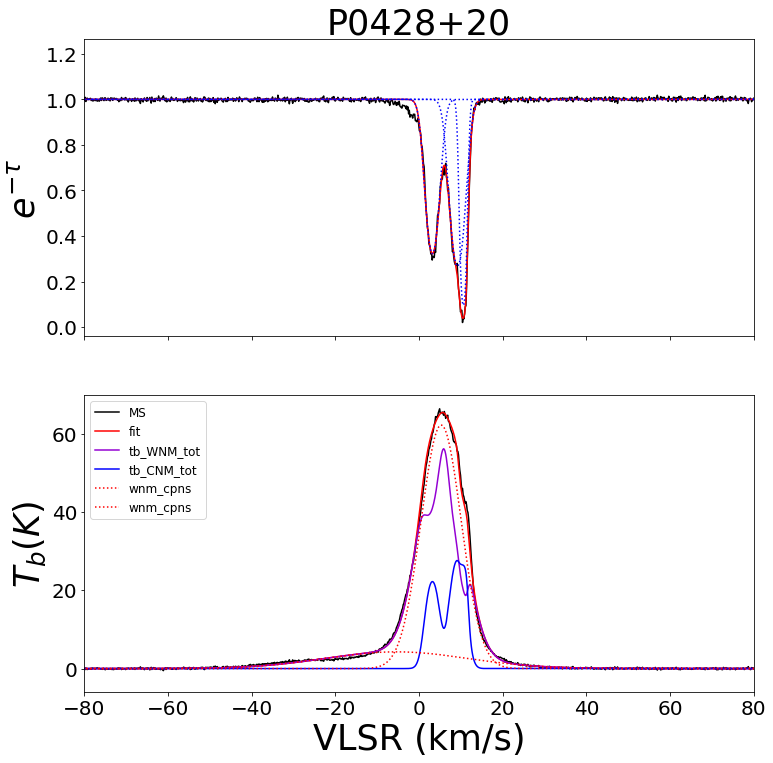



***********
P0531+19
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM P0531+19 -23.1 0.011 6.76 432.3069
CNM P0531+19 1.8 0.474 2.09 54.6496
CNM P0531+19 5.5 0.229 8.74 219.6954
CNM P0531+19 9.6 0.166 1.87 136.6119

 (CEN, HGT, WID)
WNM P0531+19 3.1 31.04 23.65
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


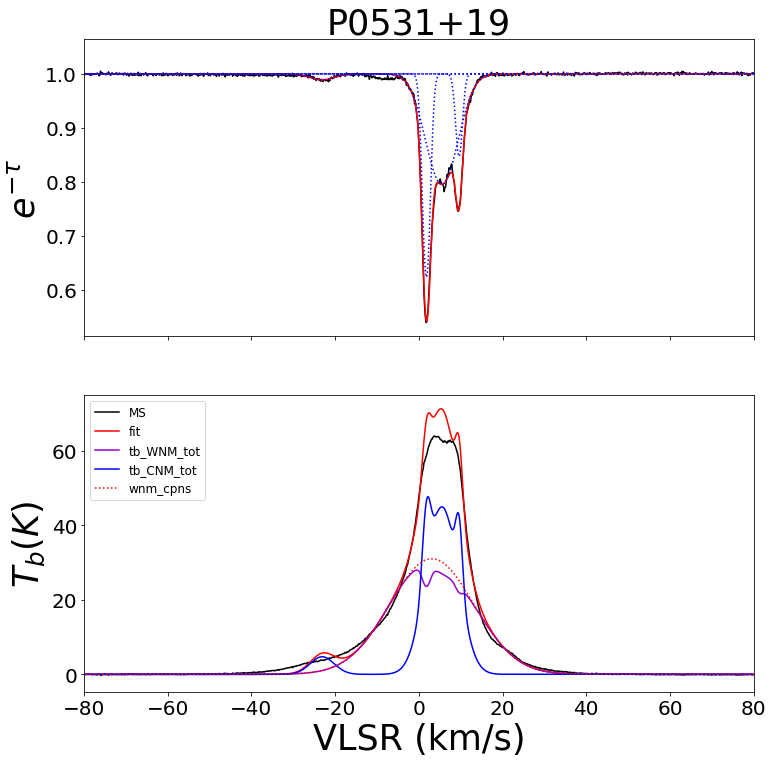



***********
3C208.0
Number of CNM components:  0
Number of WNM components:  5

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C208.0 -25.9 0.76 11.3
WNM 3C208.0 -4.0 3.39 4.34
WNM 3C208.0 0.3 2.37 3.72
WNM 3C208.0 0.4 5.13 19.32
WNM 3C208.0 5.9 6.09 3.63
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


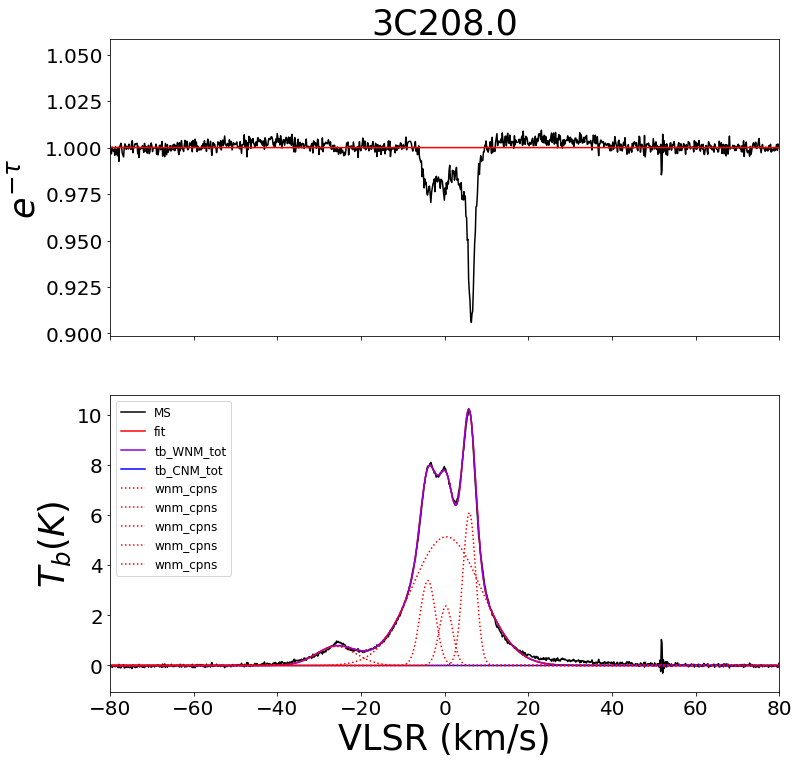



***********
3C172.0
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C172.0 1.5 0.059 4.33 75.5548
CNM 3C172.0 9.4 0.031 5.62 53.4149

 (CEN, HGT, WID)
WNM 3C172.0 -8.8 1.9 65.5
WNM 3C172.0 2.5 13.58 18.46
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


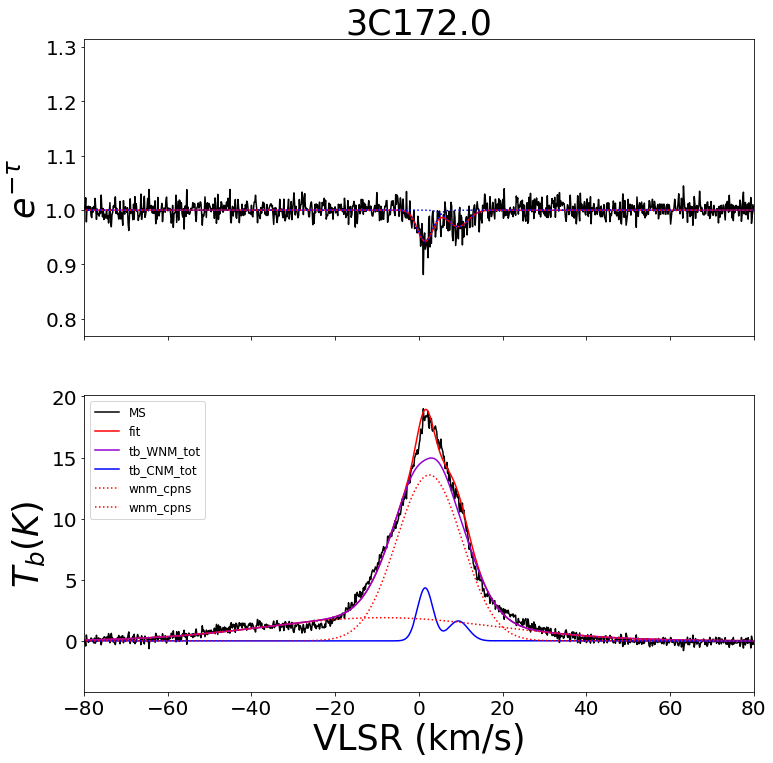



***********
3C98
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C98 -1.0 0.092 4.87 24.1367
CNM 3C98 9.5 0.297 1.35 32.8353
CNM 3C98 9.5 0.508 5.21 111.6101
CNM 3C98 23.0 0.041 6.82 164.3102

 (CEN, HGT, WID)
WNM 3C98 6.3 17.0 14.86
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


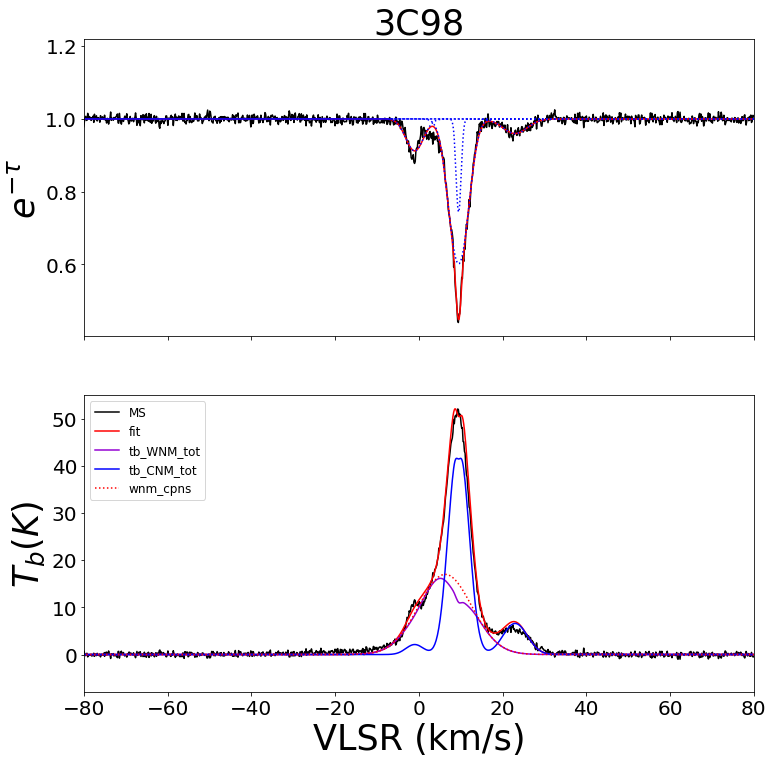



***********
4C19.44
Number of CNM components:  0
Number of WNM components:  4

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 4C19.44 -11.4 0.92 37.36
WNM 4C19.44 -6.3 4.14 3.13
WNM 4C19.44 -3.4 7.84 9.7
WNM 4C19.44 -2.8 5.86 2.18
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


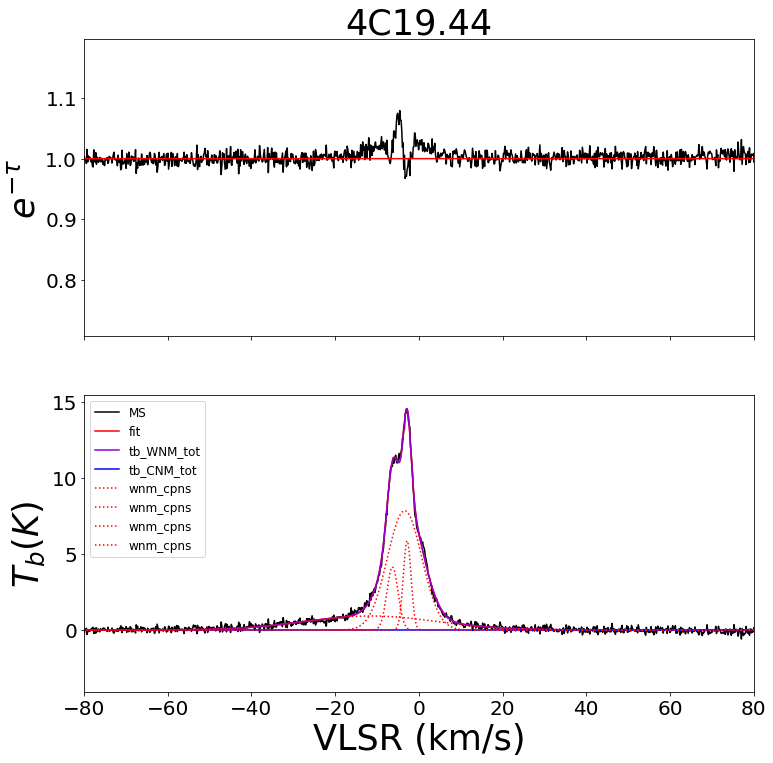



***********
3C167
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C167 22.6 0.252 21.71 197.3132
CNM 3C167 42.2 0.941 8.01 94.8362
CNM 3C167 49.3 0.386 2.09 31.9161

 (CEN, HGT, WID)
WNM 3C167 7.1 23.71 13.83
WNM 3C167 38.3 32.37 20.6
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


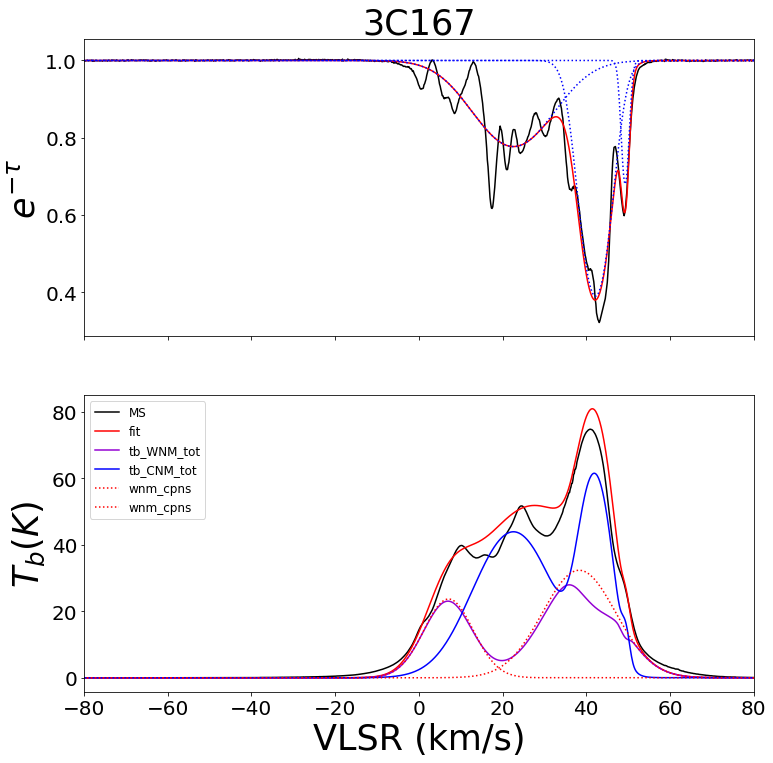



***********
3C286
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C286 -13.1 1.79 54.01
WNM 3C286 -6.0 1.16 7.27
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


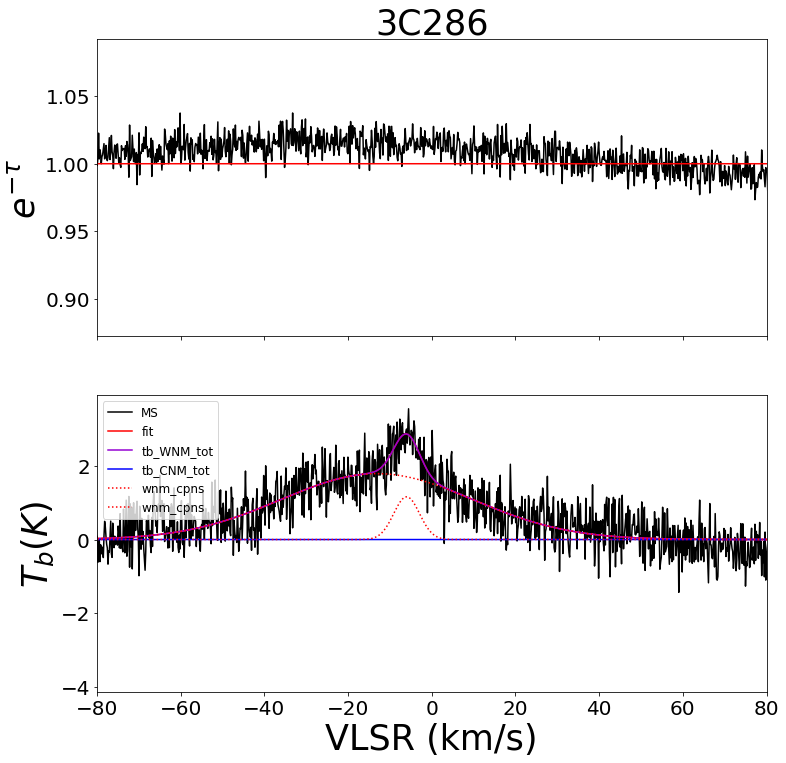



***********
3C64
Number of CNM components:  2
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C64 -10.8 0.29 5.1 103.7584
CNM 3C64 0.2 0.086 4.37 57.1831

 (CEN, HGT, WID)
WNM 3C64 -5.6 10.7 16.43
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


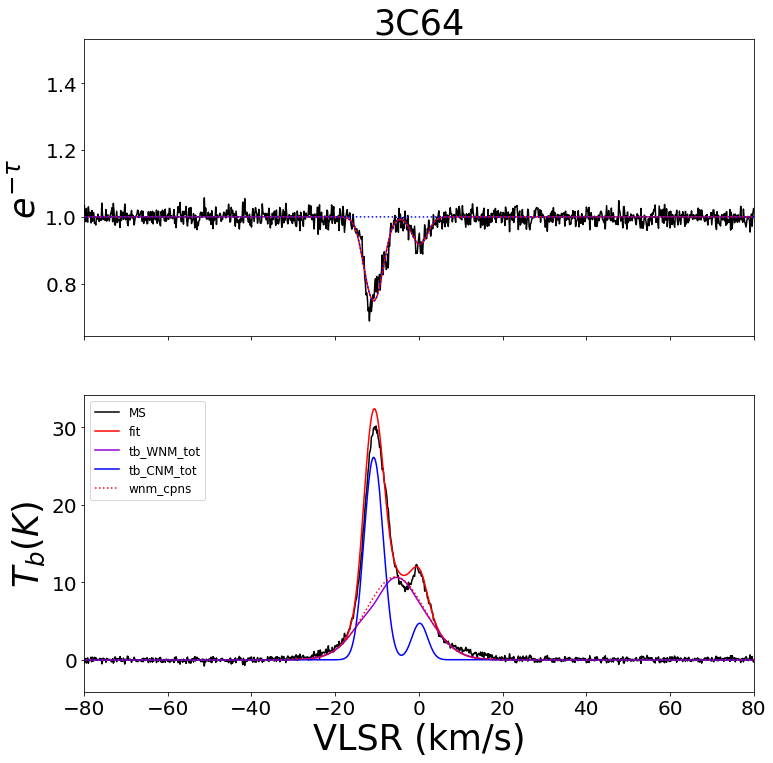



***********
CTA21
Number of CNM components:  3
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM CTA21 -0.5 0.389 4.18 83.1076
CNM CTA21 1.3 0.193 1.7 38.6466
CNM CTA21 6.9 0.108 4.17 88.4338

 (CEN, HGT, WID)
WNM CTA21 1.6 22.24 14.85
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


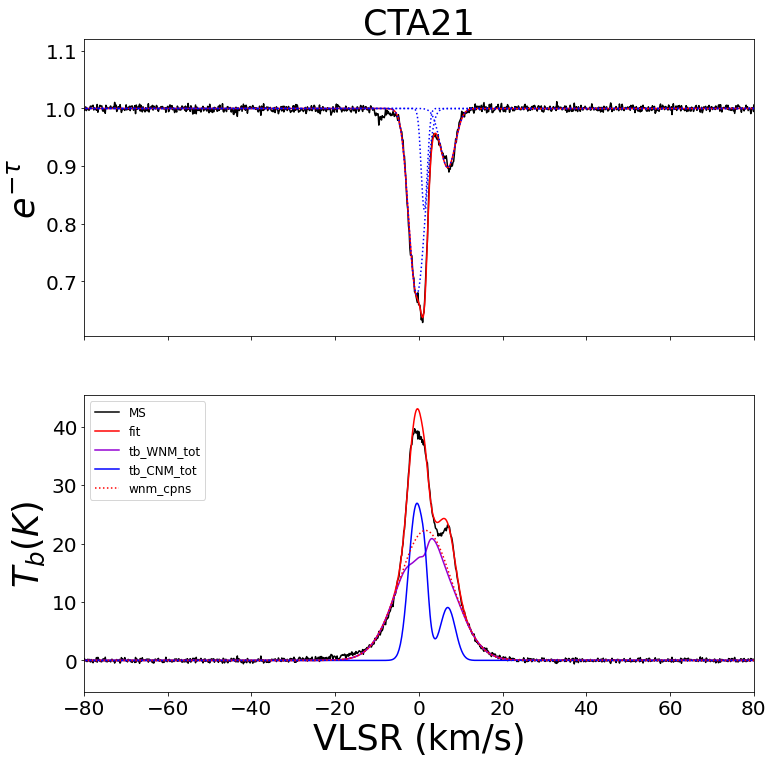



***********
3C123
Number of CNM components:  6
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C123 -72.9 0.032 4.28 39.0092
CNM 3C123 -57.8 0.008 5.62 101.0727
CNM 3C123 -19.6 0.063 3.14 56.0257
CNM 3C123 4.4 1.606 4.79 19.3961
CNM 3C123 4.7 0.596 2.32 206.3578
CNM 3C123 20.0 0.007 3.88 86.6967

 (CEN, HGT, WID)
WNM 3C123 -60.7 3.82 25.36
WNM 3C123 -7.2 10.11 37.54
WNM 3C123 4.9 88.19 6.09
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


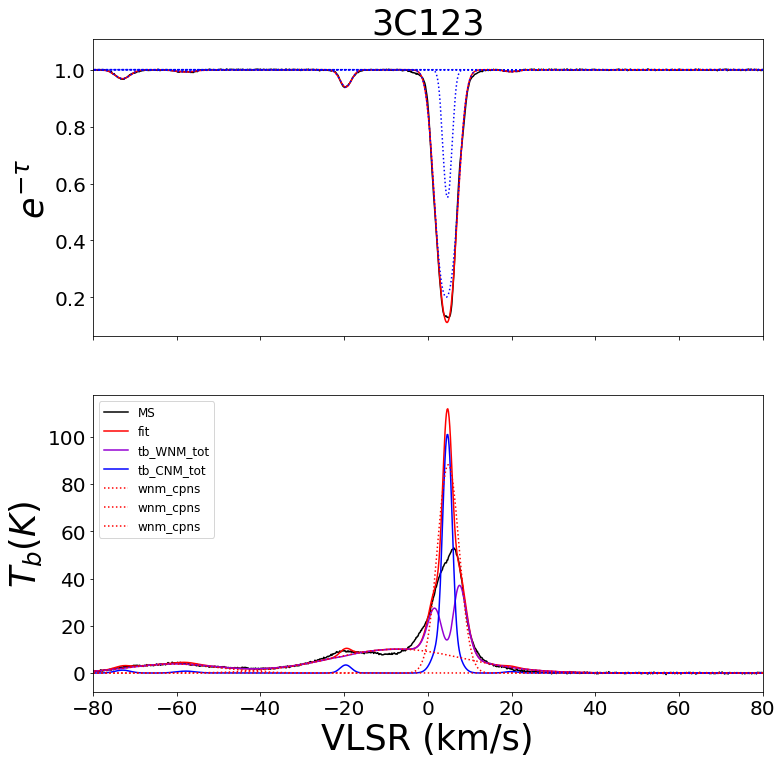



***********
4C20.33
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 4C20.33 -9.0 0.058 2.48 68.0737
CNM 4C20.33 -2.6 0.049 4.75 107.4625

 (CEN, HGT, WID)
WNM 4C20.33 -13.2 0.83 37.94
WNM 4C20.33 -5.9 6.72 11.74
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


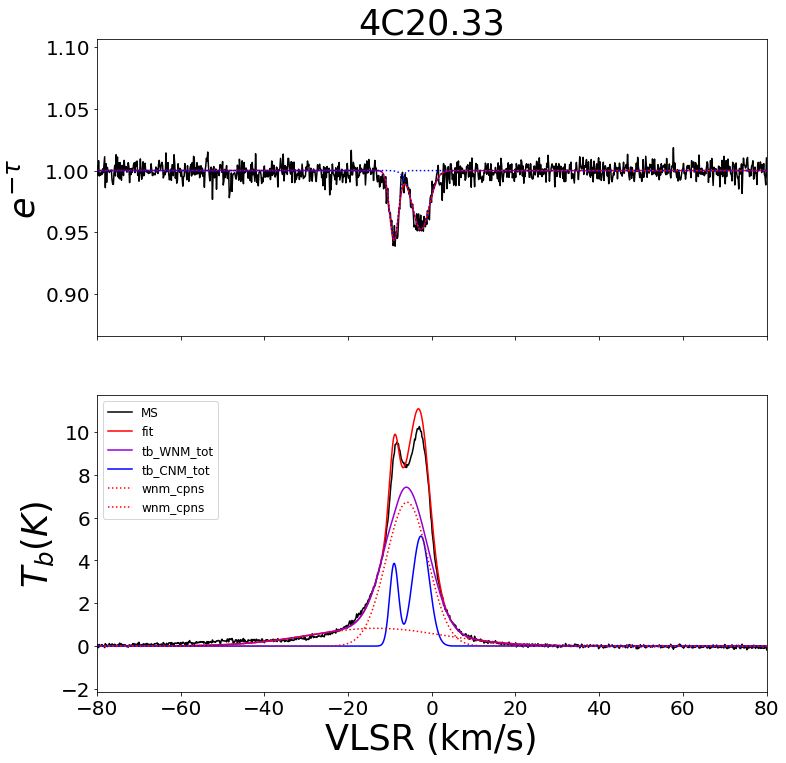



***********
T0556+19
Number of CNM components:  2
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM T0556+19 6.9 2.105 15.13 0.0863
CNM T0556+19 13.1 106.719 3.19 0.0

 (CEN, HGT, WID)
WNM T0556+19 8.6 142.23 20.06
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


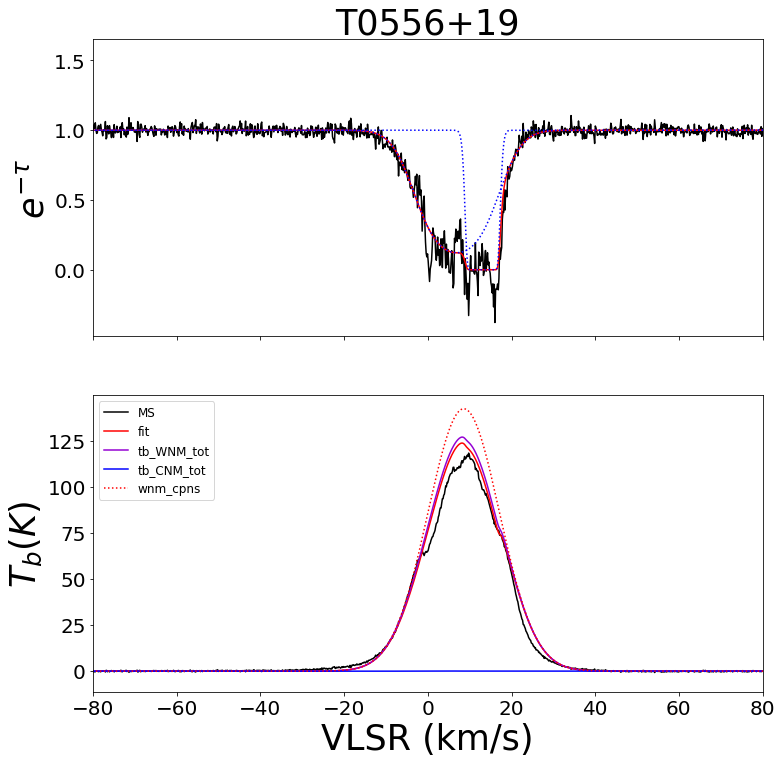



***********
P1117+14
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM P1117+14 -29.3 1.36 43.23
WNM P1117+14 -5.3 1.48 14.85
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


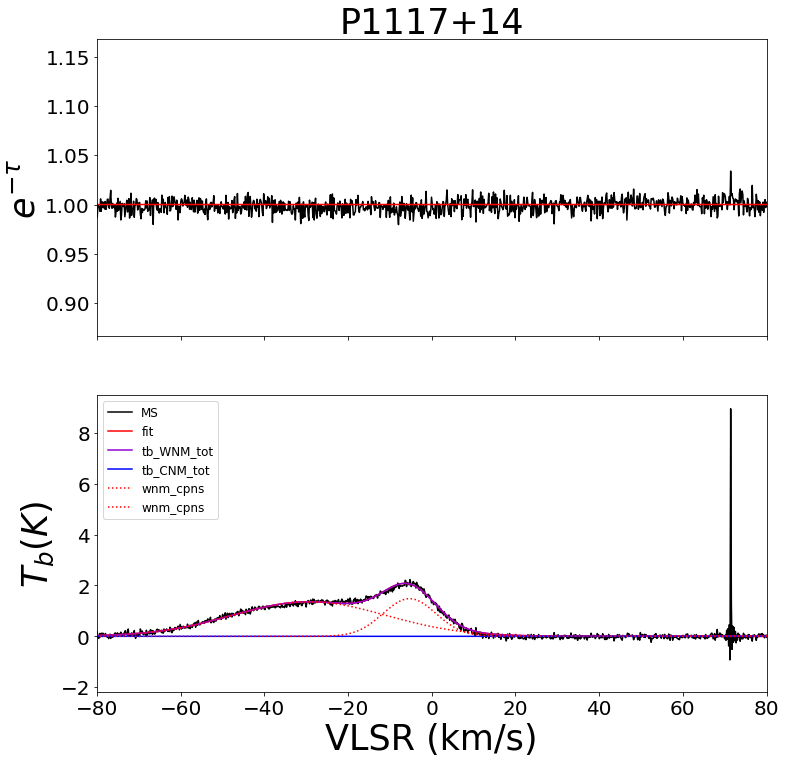



***********
3C264.0
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C264.0 -36.2 0.84 10.27
WNM 3C264.0 -29.6 1.62 49.4
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


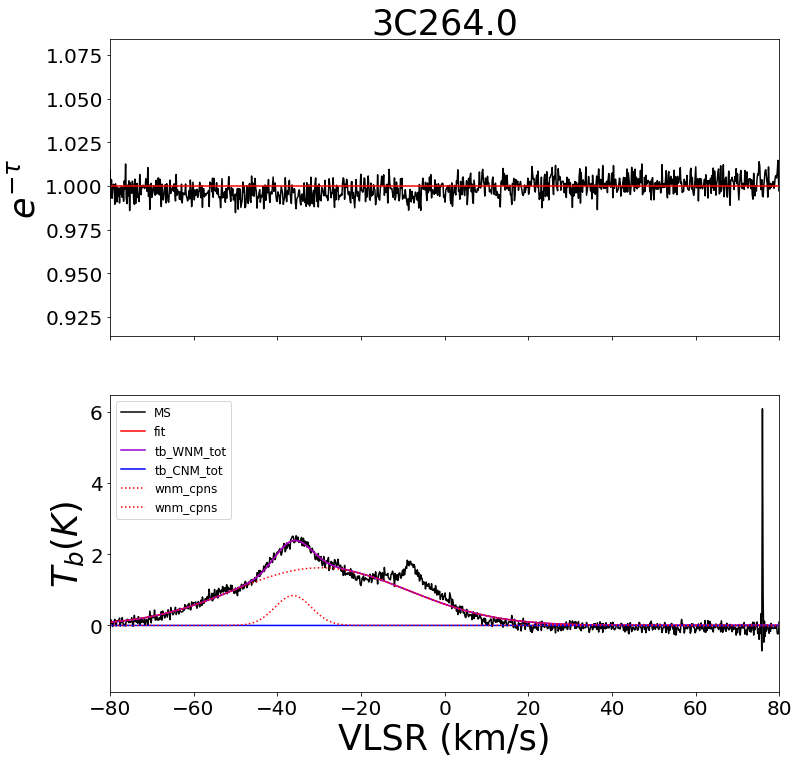



***********
3C208.1
Number of CNM components:  0
Number of WNM components:  5

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C208.1 -25.4 0.63 17.18
WNM 3C208.1 -3.4 2.72 3.45
WNM 3C208.1 1.0 4.42 18.85
WNM 3C208.1 1.6 3.07 4.03
WNM 3C208.1 6.8 6.49 4.01
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


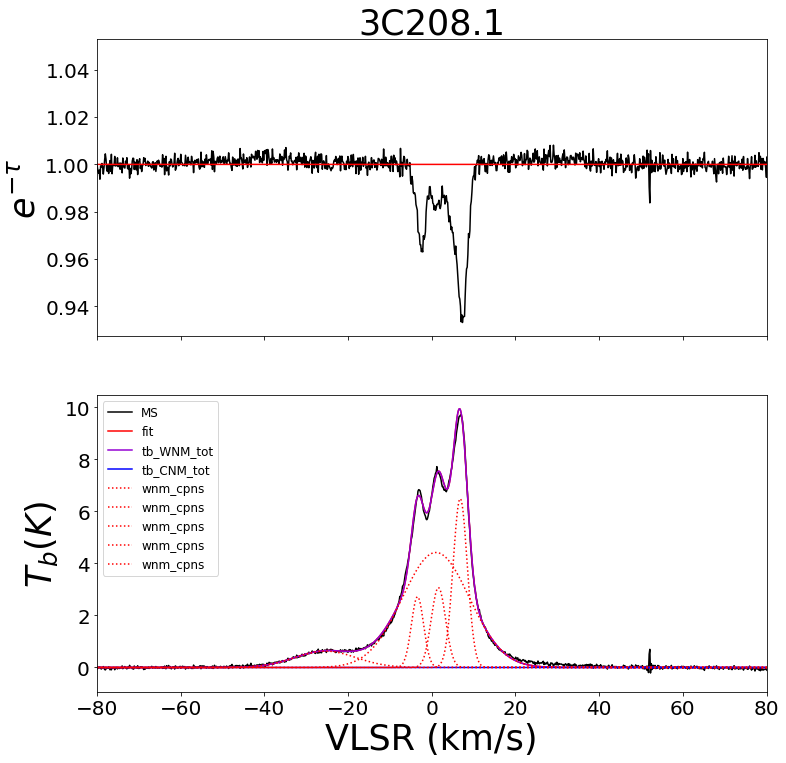



***********
3C433
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C433 2.1 0.162 1.45 23.3029
CNM 3C433 3.0 0.258 4.12 123.2889
CNM 3C433 6.9 0.076 1.97 111.7096
CNM 3C433 16.0 0.053 3.11 106.4441

 (CEN, HGT, WID)
WNM 3C433 3.5 10.26 25.31
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


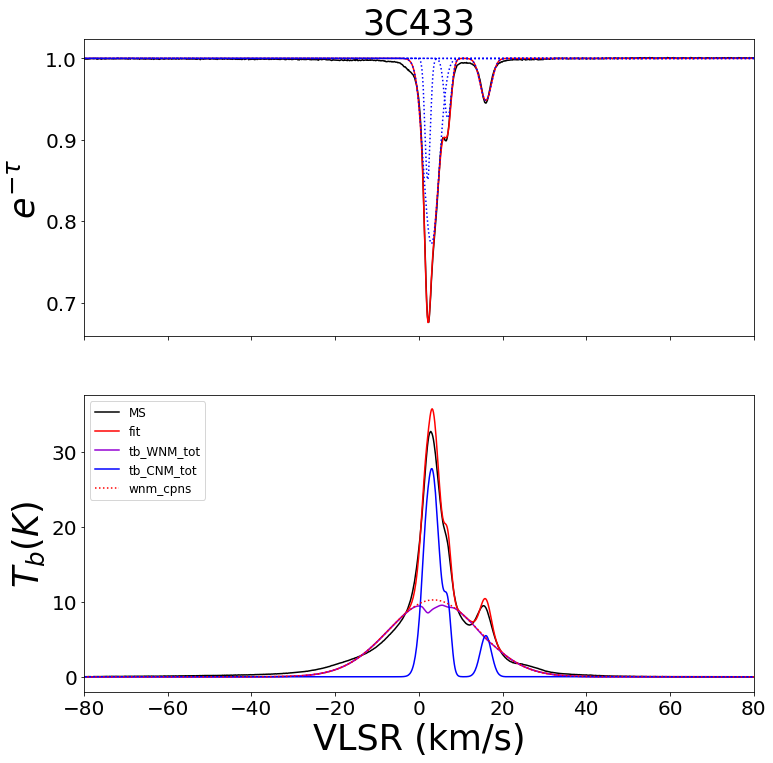



***********
3C223

***********
3C409
Number of CNM components:  6
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C409 3.9 0.451 3.03 38.8075
CNM 3C409 7.7 0.331 2.91 49.9444
CNM 3C409 13.7 0.861 1.96 44.799
CNM 3C409 14.0 0.413 6.9 36.6831
CNM 3C409 15.7 0.753 1.69 45.1378
CNM 3C409 23.3 0.035 4.27 190.7745

 (CEN, HGT, WID)
WNM 3C409 -63.7 2.85 24.05
WNM 3C409 11.2 45.67 12.97
WNM 3C409 15.3 11.45 30.83
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


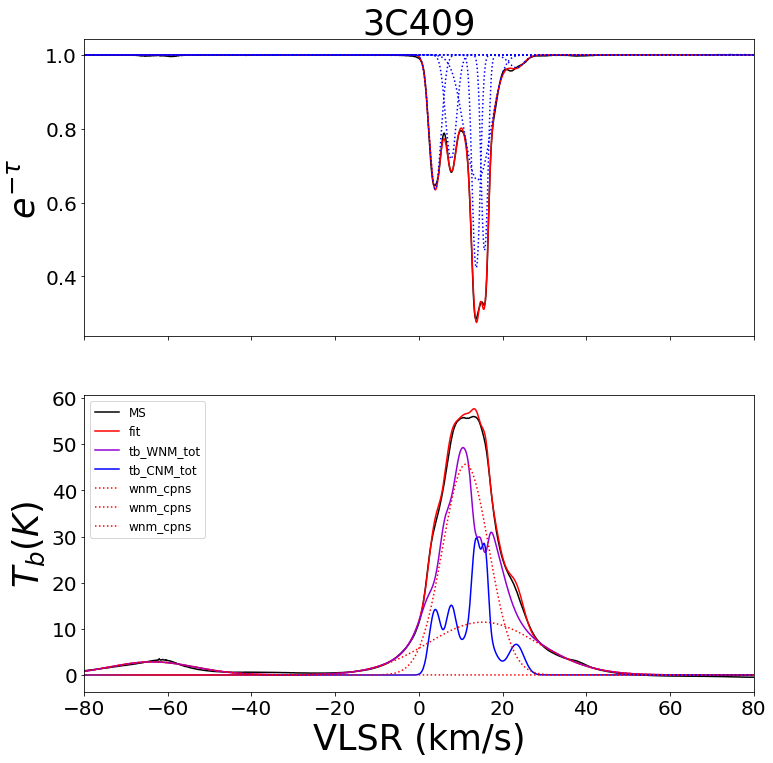



***********
3C293
Number of CNM components:  0
Number of WNM components:  3

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C293 -30.3 0.58 8.85
WNM 3C293 -13.7 1.25 41.71
WNM 3C293 -5.2 1.07 8.32
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


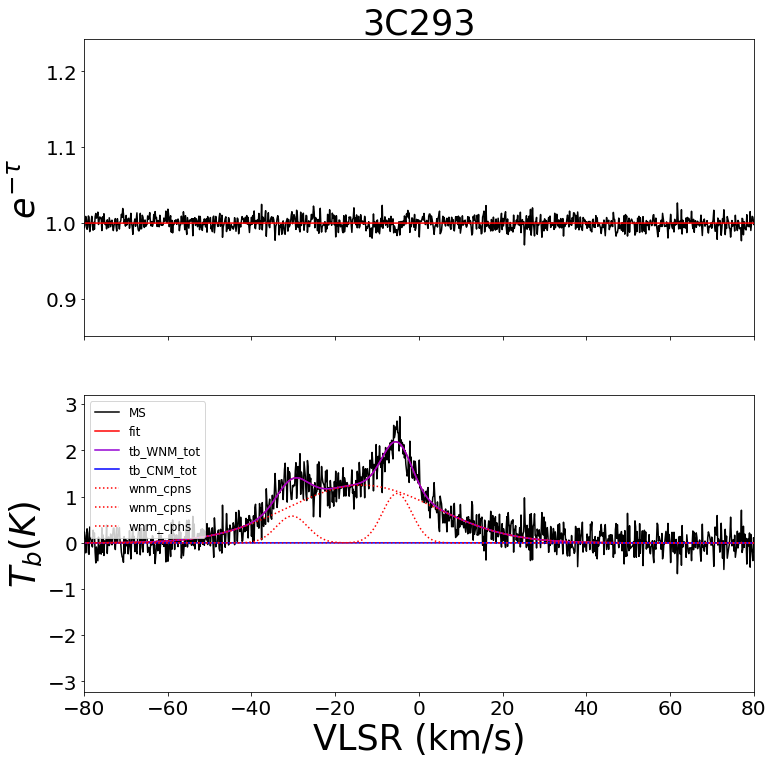



***********
3C263.1
Number of CNM components:  0
Number of WNM components:  4

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C263.1 -55.2 0.84 9.43
WNM 3C263.1 -40.1 1.02 11.7
WNM 3C263.1 -38.2 0.99 52.12
WNM 3C263.1 -5.9 0.94 16.58
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


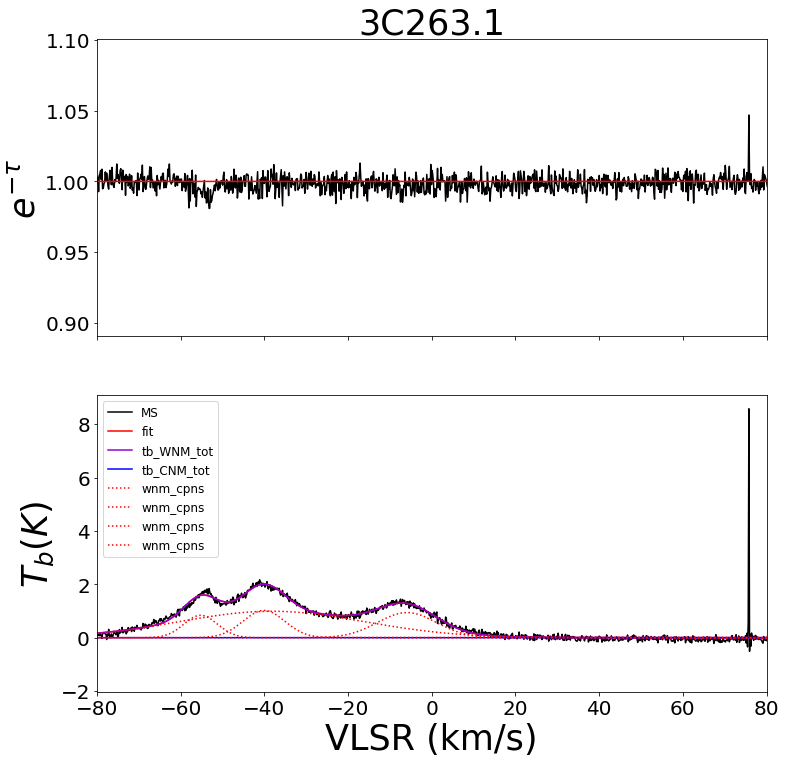



***********
P0347+05
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM P0347+05 8.0 1.051 3.54 70.8364
CNM P0347+05 12.1 0.171 4.87 198.1509

 (CEN, HGT, WID)
WNM P0347+05 -0.6 5.3 2.93
WNM P0347+05 5.7 18.69 16.14
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


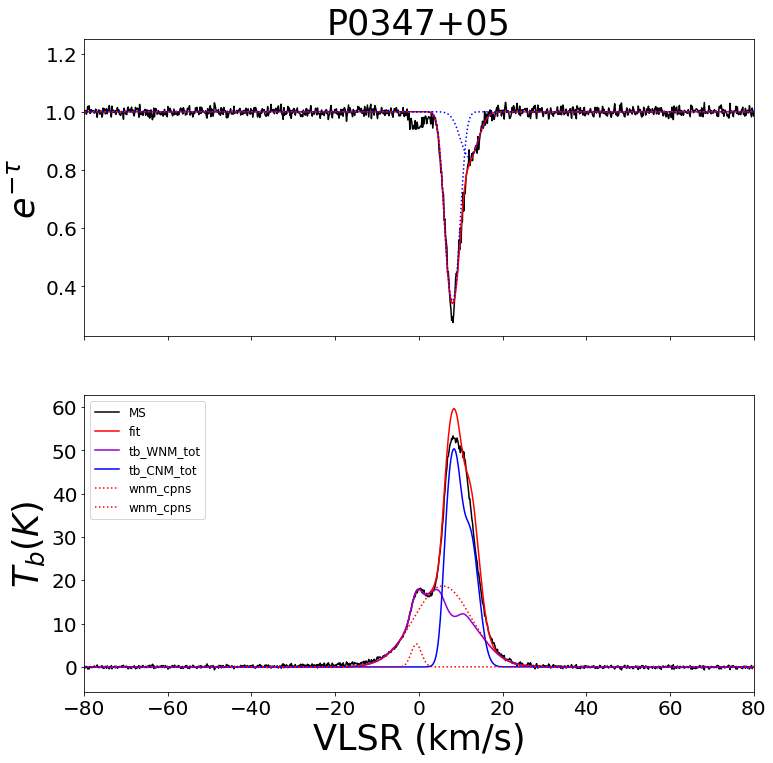



***********
3C237
Number of CNM components:  4
Number of WNM components:  1

 CEN, HGT, WID, Tspin
CNM 3C237 -5.7 0.006 16.31 822.2161
CNM 3C237 -3.0 0.005 2.48 380.4884
CNM 3C237 1.9 0.398 1.19 16.4291
CNM 3C237 30.1 0.003 6.04 340.5978

 (CEN, HGT, WID)
WNM 3C237 12.3 0.28 120.09
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


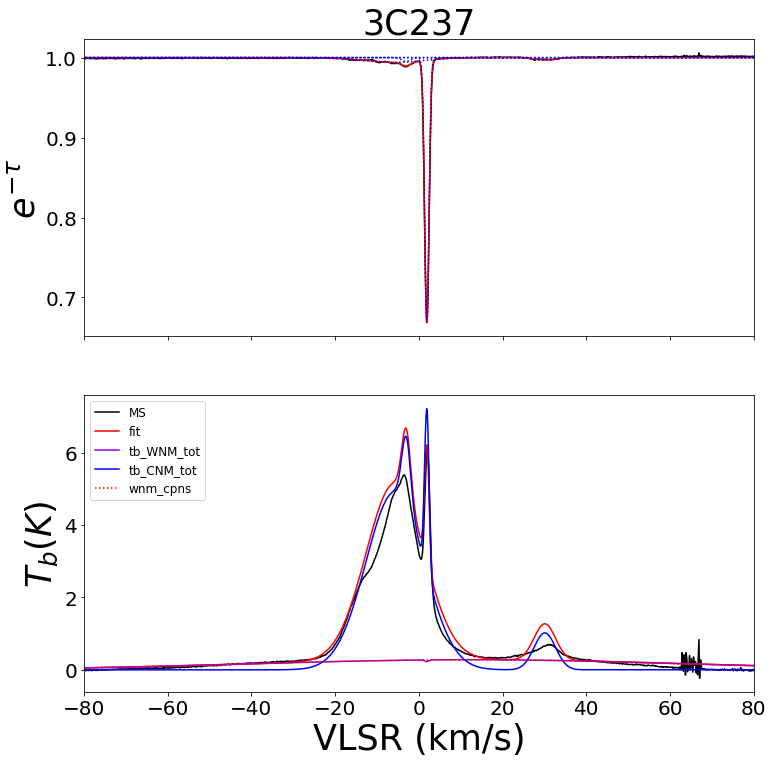



***********
3C120
Number of CNM components:  3
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C120 6.2 0.736 1.33 42.725
CNM 3C120 7.6 1.666 4.48 48.3826
CNM 3C120 10.2 0.634 1.91 50.672

 (CEN, HGT, WID)
WNM 3C120 -19.1 2.15 17.07
WNM 3C120 5.2 5.99 20.35
WNM 3C120 8.1 41.3 6.34
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


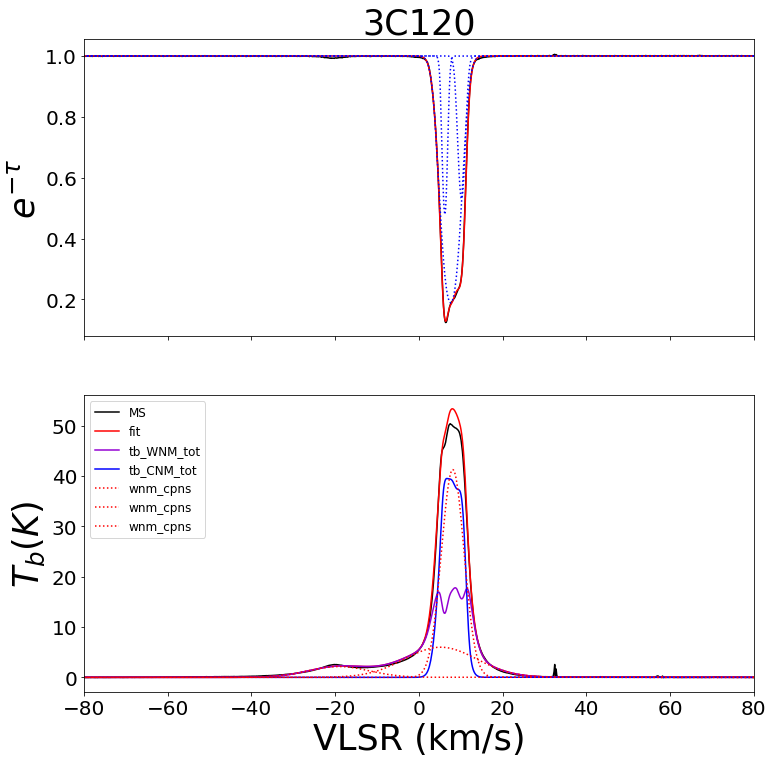



***********
3C225a
Number of CNM components:  2
Number of WNM components:  4

 CEN, HGT, WID, Tspin
CNM 3C225a -2.6 0.013 12.68 501.4783
CNM 3C225a 4.0 0.313 1.32 25.7822

 (CEN, HGT, WID)
WNM 3C225a -37.1 4.35 4.22
WNM 3C225a -27.1 2.97 7.07
WNM 3C225a -13.3 1.14 42.44
WNM 3C225a -4.5 1.76 5.13
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


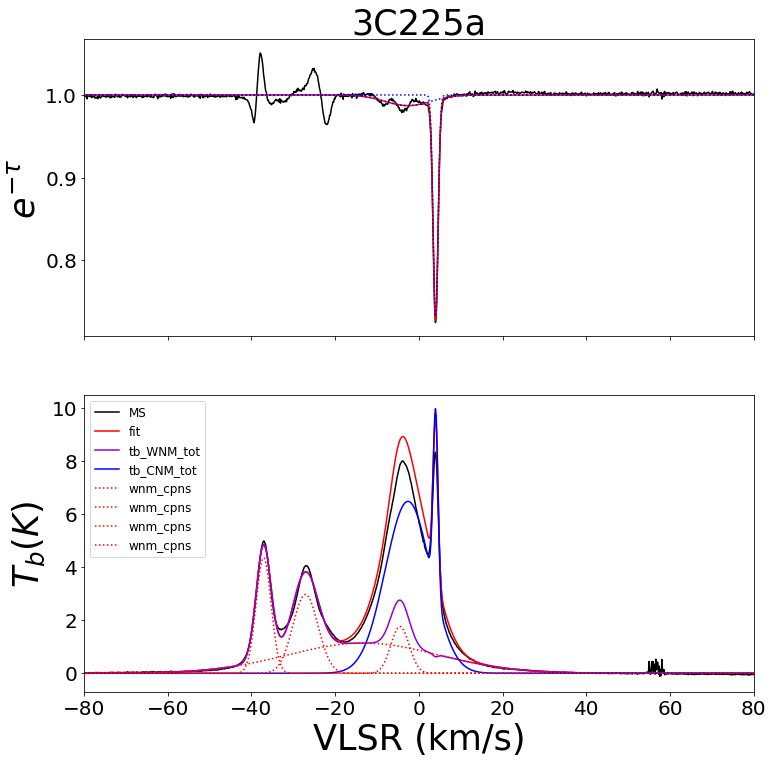



***********
4C07.32
Number of CNM components:  1
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 4C07.32 -1.9 0.177 2.19 51.2361

 (CEN, HGT, WID)
WNM 4C07.32 -11.5 2.26 24.96
WNM 4C07.32 -1.9 4.71 7.48
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


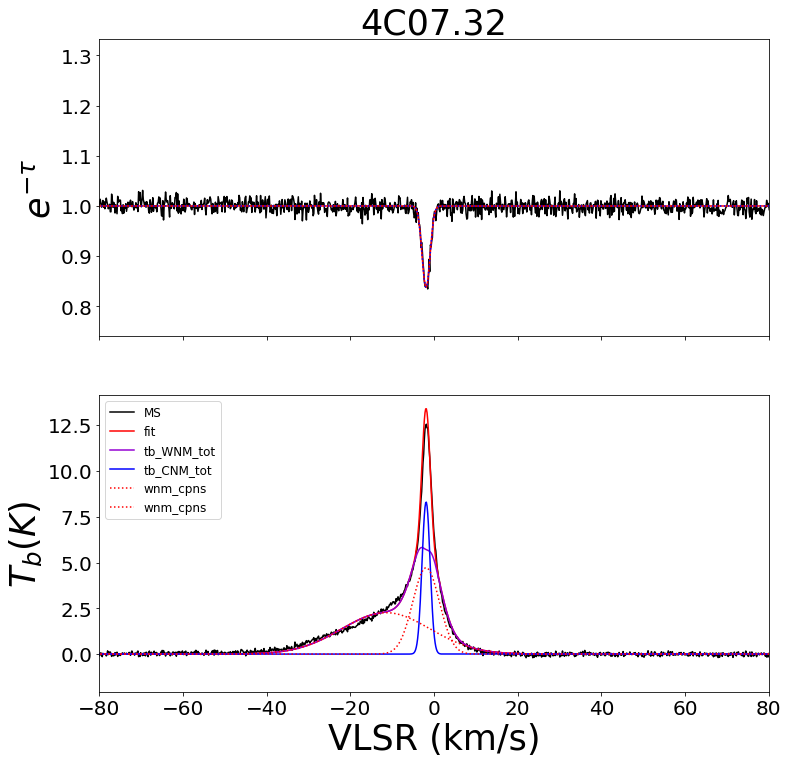



***********
3C132
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C132 1.8 0.351 5.43 36.0365
CNM 3C132 8.1 1.542 2.42 63.5947
CNM 3C132 13.0 0.26 5.68 99.6416

 (CEN, HGT, WID)
WNM 3C132 -16.4 5.52 45.87
WNM 3C132 5.7 39.75 14.5
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


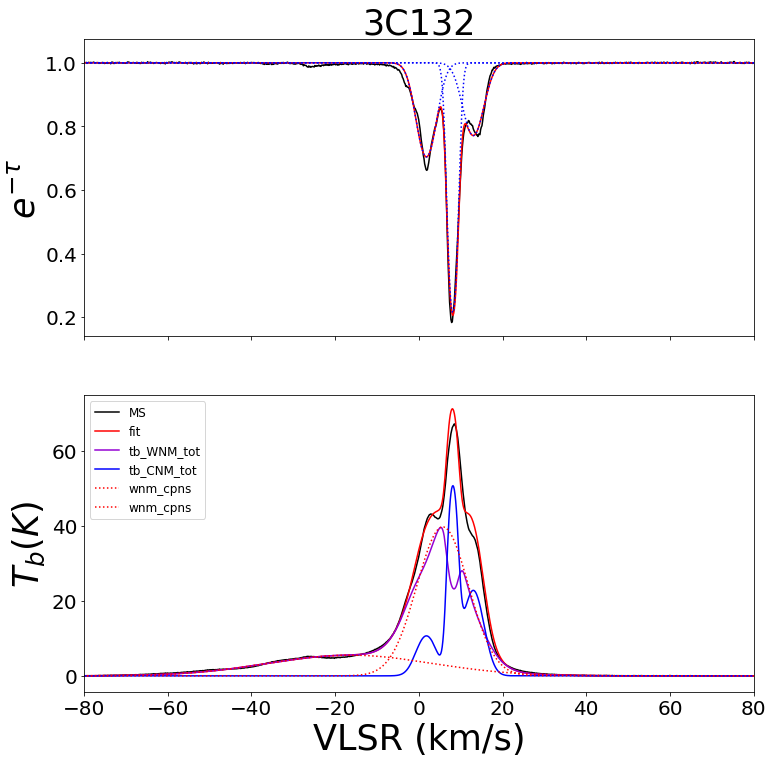



***********
3C410
Number of CNM components:  8
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C410 -46.3 0.019 2.53 53.3094
CNM 3C410 -23.2 0.042 3.52 249.9305
CNM 3C410 -0.7 0.369 3.51 49.7239
CNM 3C410 2.6 0.654 4.33 64.0644
CNM 3C410 7.8 2.214 2.77 67.7184
CNM 3C410 11.3 0.688 3.55 73.3978
CNM 3C410 17.8 0.118 4.81 5.3518
CNM 3C410 25.0 0.103 3.54 100.08

 (CEN, HGT, WID)
WNM 3C410 -68.3 6.58 37.29
WNM 3C410 -21.5 8.24 16.36
WNM 3C410 8.0 59.82 21.77
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


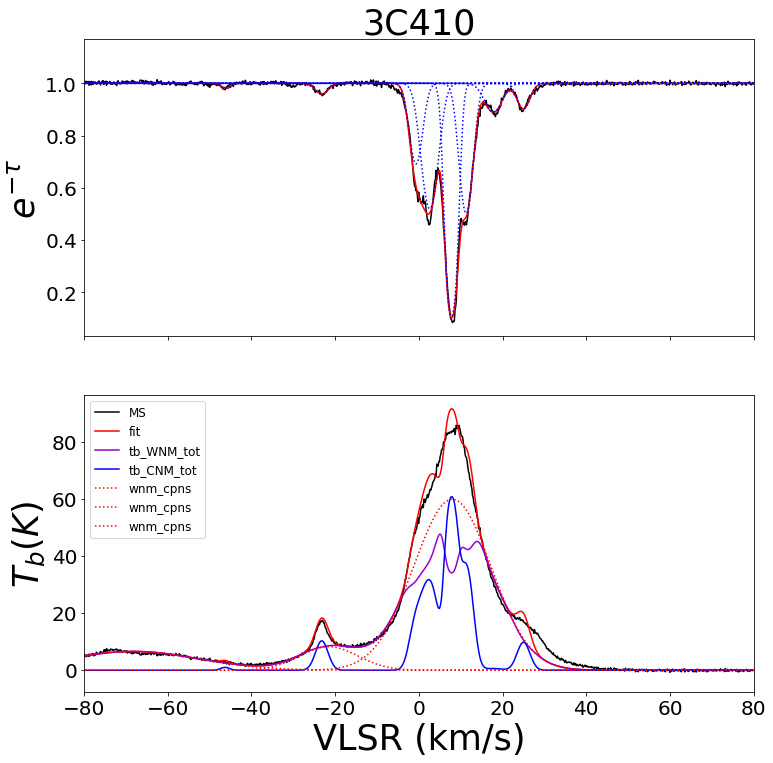



***********
3C93.1
Number of CNM components:  2
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C93.1 6.5 0.86 2.99 39.7099
CNM 3C93.1 8.8 1.243 2.54 32.8938

 (CEN, HGT, WID)
WNM 3C93.1 -19.5 1.72 6.08
WNM 3C93.1 -13.1 4.26 43.14
WNM 3C93.1 7.2 32.88 7.88
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


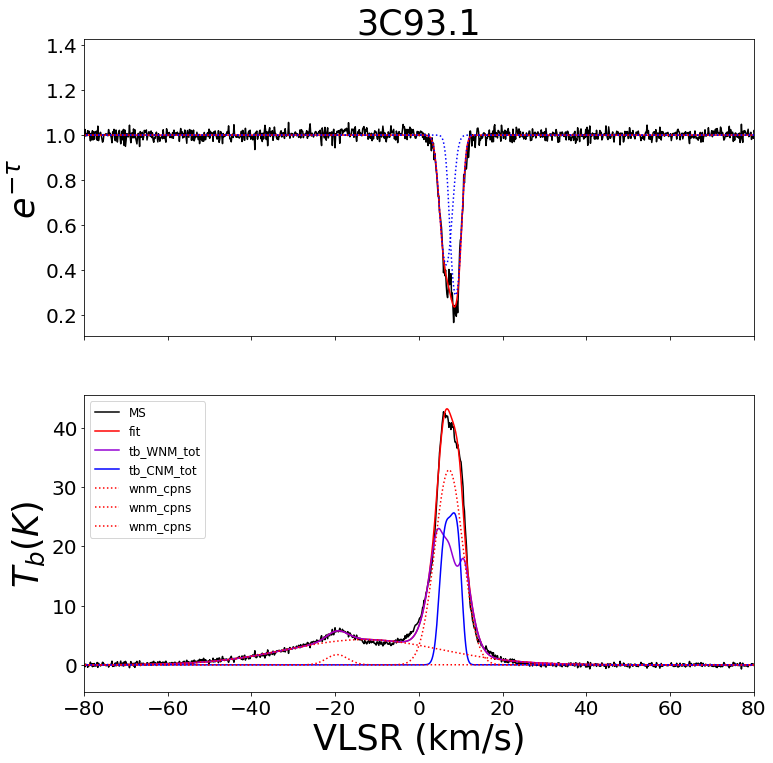



***********
3C348
Number of CNM components:  3
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM 3C348 -2.2 0.259 1.65 15.3054
CNM 3C348 0.5 0.604 2.12 37.8172
CNM 3C348 7.2 0.078 3.73 136.437

 (CEN, HGT, WID)
WNM 3C348 -0.4 15.39 6.29
WNM 3C348 2.8 3.31 35.08
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


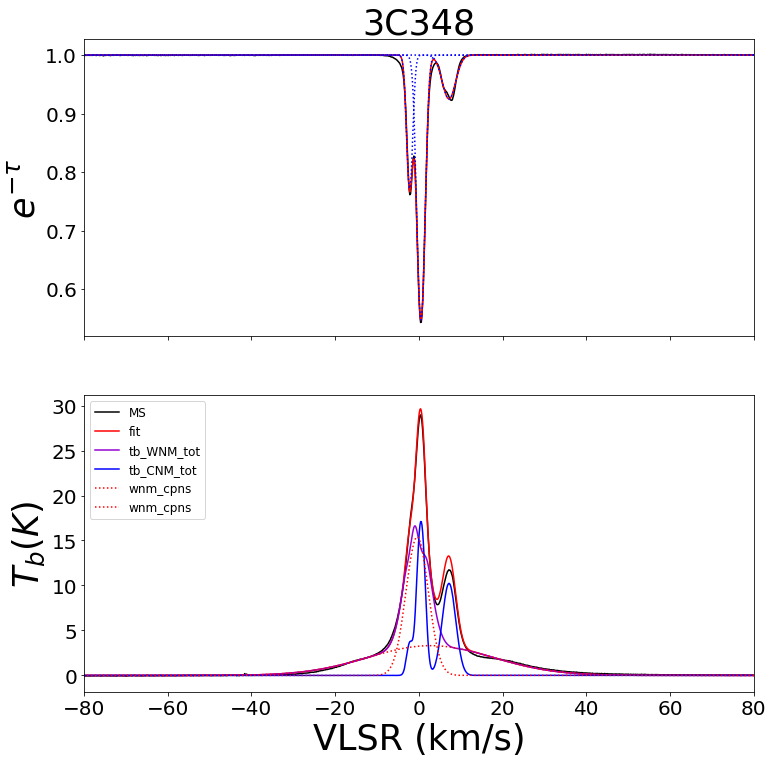



***********
4C13.67
Number of CNM components:  3
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 4C13.67 2.0 1.161 2.1 29.7593
CNM 4C13.67 6.2 1.019 4.01 34.1145
CNM 4C13.67 20.2 0.03 8.2 116.222

 (CEN, HGT, WID)
WNM 4C13.67 -67.8 2.94 32.25
WNM 4C13.67 4.9 30.01 8.37
WNM 4C13.67 20.4 6.63 46.69
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


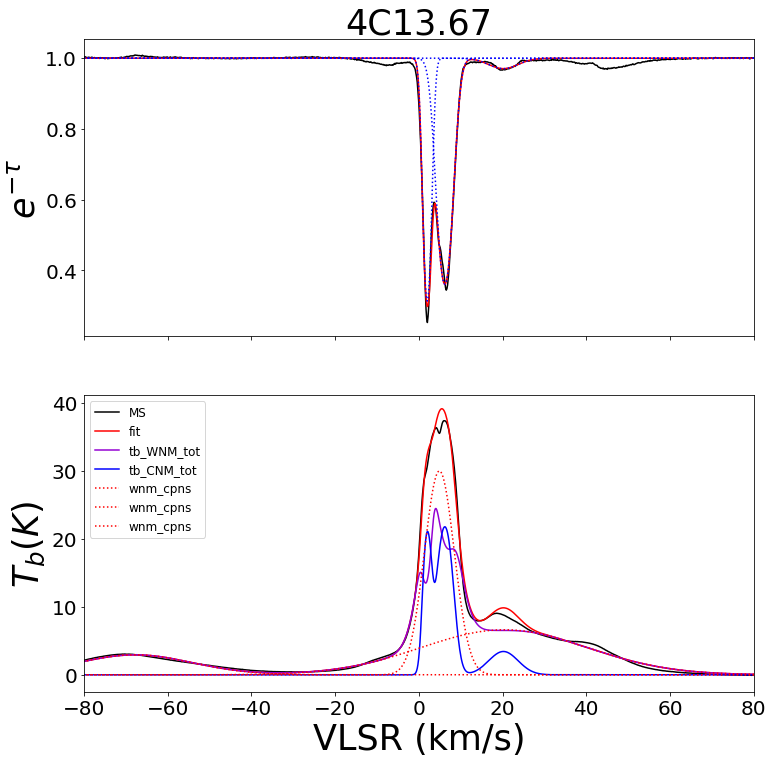



***********
P1055+20
Number of CNM components:  2
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM P1055+20 -4.6 0.01 7.94 216.5141
CNM P1055+20 -3.6 0.073 2.23 51.7899

 (CEN, HGT, WID)
WNM P1055+20 -32.2 1.05 29.62
WNM P1055+20 -4.9 1.67 18.36
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


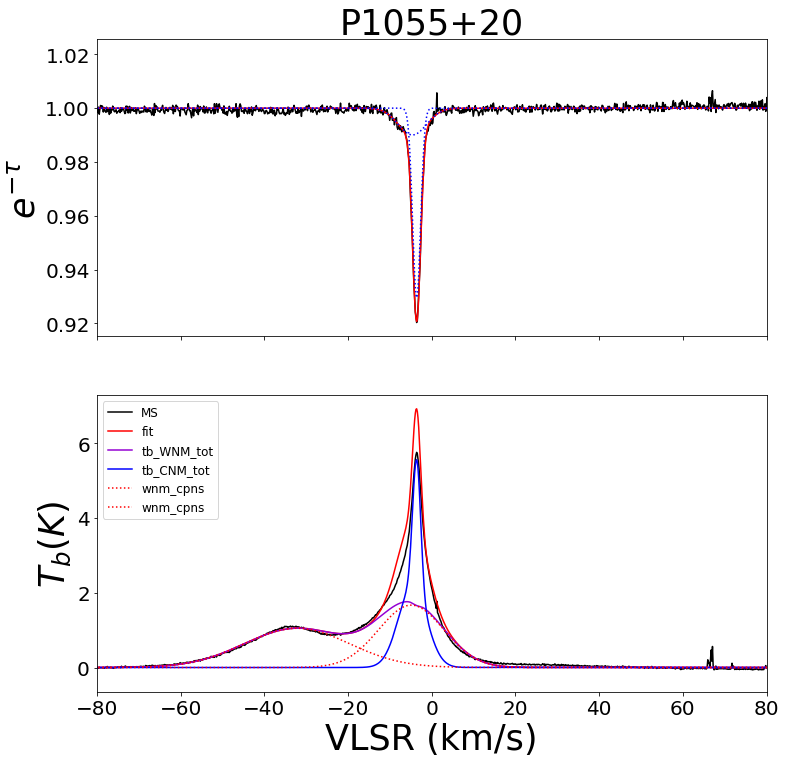



***********
3C454.0
Number of CNM components:  2
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C454.0 -1.5 0.045 6.39 188.9404
CNM 3C454.0 3.9 0.093 3.12 80.5501

 (CEN, HGT, WID)
WNM 3C454.0 -50.9 1.69 28.82
WNM 3C454.0 -7.7 2.75 26.54
WNM 3C454.0 -0.2 6.98 12.94
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


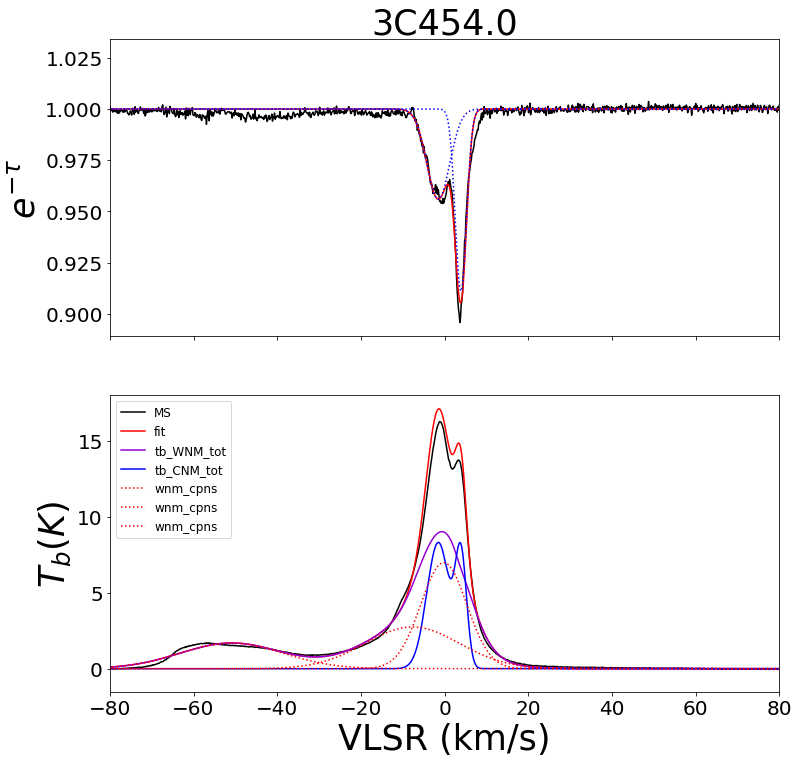



***********
3C190.0
Number of CNM components:  0
Number of WNM components:  2

 CEN, HGT, WID, Tspin

 (CEN, HGT, WID)
WNM 3C190.0 2.8 6.61 17.67
WNM 3C190.0 23.5 1.68 16.51
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


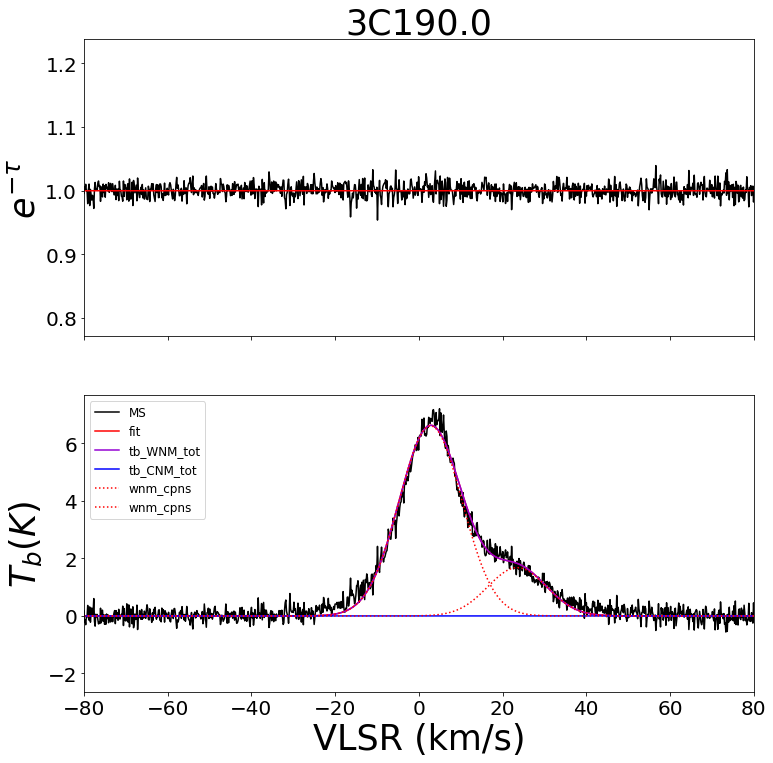



***********
P0320+05
Number of CNM components:  4
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM P0320+05 -6.3 0.478 5.1 64.7625
CNM P0320+05 -4.4 0.223 1.37 45.3728
CNM P0320+05 5.8 0.372 3.04 61.7507
CNM P0320+05 11.7 0.408 2.82 50.6825

 (CEN, HGT, WID)
WNM P0320+05 -1.4 12.41 14.86
WNM P0320+05 10.6 15.6 8.39
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


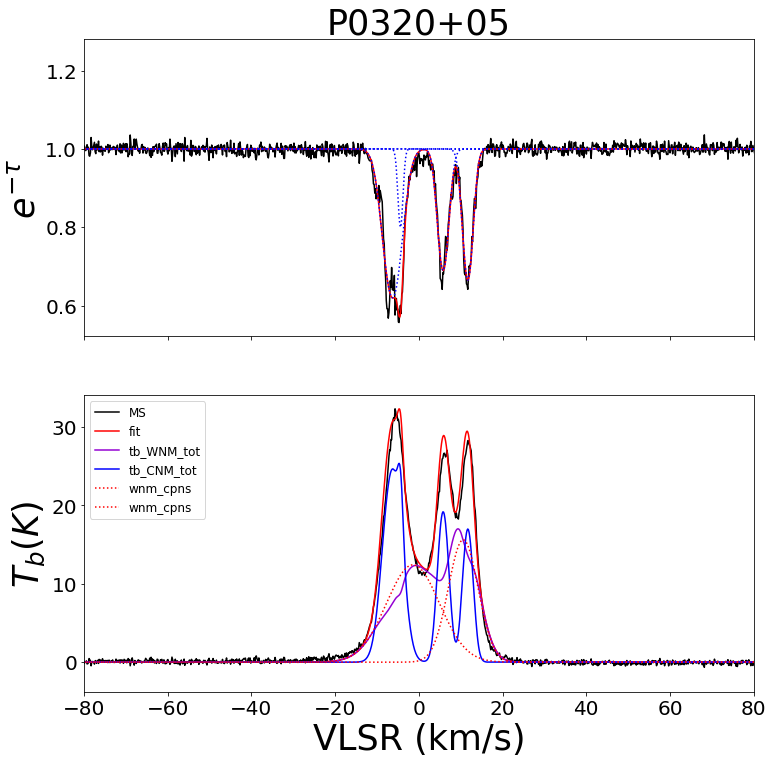



***********
3C274.1
Number of CNM components:  2
Number of WNM components:  3

 CEN, HGT, WID, Tspin
CNM 3C274.1 -26.8 0.009 3.91 162.314
CNM 3C274.1 -1.6 0.102 2.94 49.0172

 (CEN, HGT, WID)
WNM 3C274.1 -28.0 1.52 9.33
WNM 3C274.1 -14.9 0.93 53.31
WNM 3C274.1 0.4 6.56 6.36
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


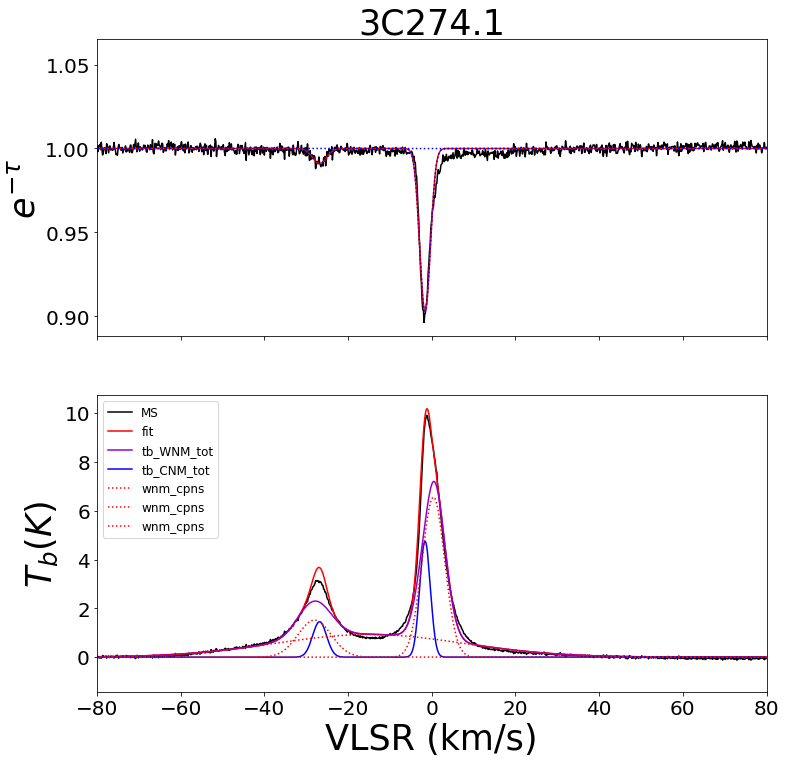



***********
3C207
Number of CNM components:  2
Number of WNM components:  4

 CEN, HGT, WID, Tspin
CNM 3C207 4.2 0.25 5.25 29.717
CNM 3C207 15.4 0.298 2.43 23.5863

 (CEN, HGT, WID)
WNM 3C207 -0.1 1.66 36.92
WNM 3C207 1.4 2.51 1.95
WNM 3C207 3.1 11.29 10.16
WNM 3C207 13.8 7.71 5.4
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


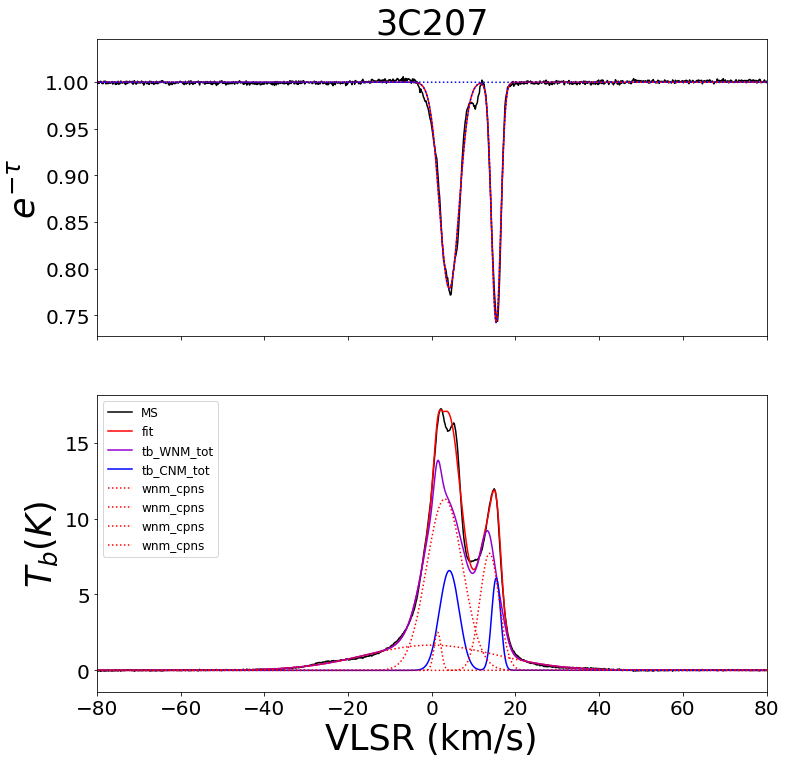



***********
T0629+10
Number of CNM components:  6
Number of WNM components:  2

 CEN, HGT, WID, Tspin
CNM T0629+10 -11.9 0.152 1.29 35.5758
CNM T0629+10 4.9 1.605 4.37 40.7288
CNM T0629+10 16.9 0.297 28.11 206.7169
CNM T0629+10 23.3 0.354 3.03 54.5708
CNM T0629+10 30.9 0.271 2.81 71.2758
CNM T0629+10 33.9 1.285 1.7 25.9728

 (CEN, HGT, WID)
WNM T0629+10 4.5 61.72 8.46
WNM T0629+10 28.1 32.94 18.82
Tbg_408 (MHz):  32.4
T_sky:  3.710460788976988


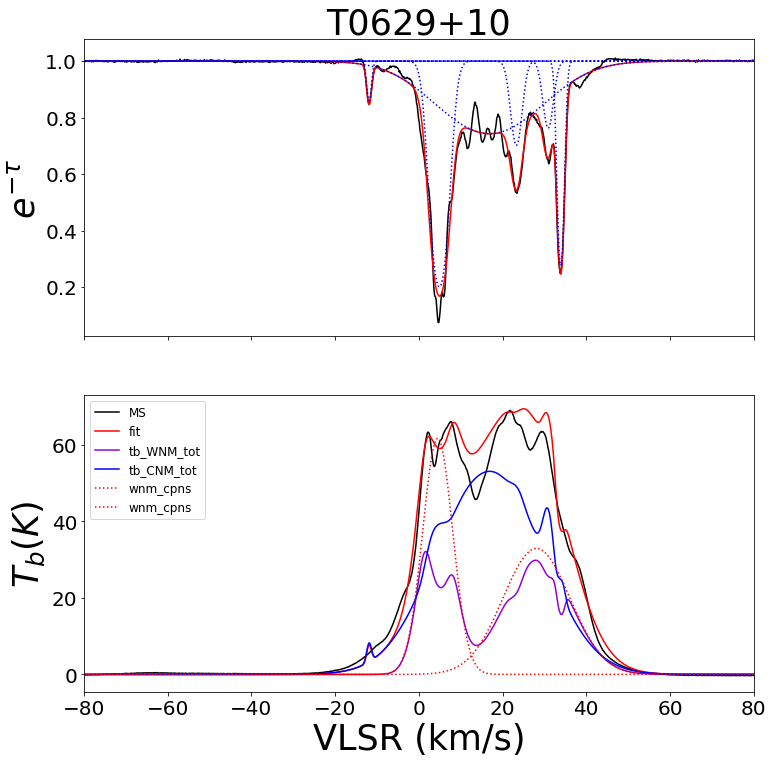

In [121]:
for sc, dat in msdata.items():
  print()
  print('***********')
  print(sc)
  ## N*(HI) of MS from spec-data file
  vMS     = dat['vlsr']
  texpMS  = dat['texp']  ## Origin .. not scaled
  emtMs   = dat['emt']

  if sc not in msparams:
    continue

  cencnm    = msparams[sc]['cencnm']
  sigcencnm = msparams[sc]['sigcencnm']

  widcnm    = msparams[sc]['widcnm']
  sigwidcnm = msparams[sc]['sigwidcnm']

  hgtcnm    = msparams[sc]['hgtcnm']
  sighgtcnm = msparams[sc]['sighgtcnm']

  tspin     = msparams[sc]['tspin']
  sigtspin  = msparams[sc]['sigtspin']

  ordercnm  = msparams[sc]['order']

  cenwnm    = msparams[sc]['cenwnm']
  sigcenwnm = msparams[sc]['sigcenwnm']

  hgtwnm    = msparams[sc]['hgtwnm']
  sighgtwnm = msparams[sc]['sighgtwnm']

  widwnm    = msparams[sc]['widwnm']
  sigwidwnm = msparams[sc]['sigwidwnm']

  fwnm      = msparams[sc]['fwnm']
  sigfwnm   = msparams[sc]['sigfwnm']


  ncnm = len(cencnm)
  nwnm = len(cenwnm)
  print('Number of CNM components: ', ncnm)
  print('Number of WNM components: ', nwnm)


  print('\n CEN, HGT, WID, Tspin')
  for ci,hi,wi, tsi in zip(cencnm, hgtcnm, widcnm, tspin):
    print ('CNM', sc, ci, hi, wi, tsi)

  print('\n (CEN, HGT, WID)')
  for ci,hi,wi in zip(cenwnm, hgtwnm, widwnm):
    print ('WNM', sc, ci, hi, wi)

  # e(-tau) fit
  emtfit = gfunc(vMS, 0., hgtcnm, cencnm, widcnm)
  emtfit = np.exp(-emtfit)

  # Background temperature
  gl = msdata['3C75']['gl']
  gb = msdata['3C75']['gb']
  tbg408 = get_tb_408(gl, gb, inf408.tb_408)
  tsky   = 2.725 + tbg408*(408./1420.405)**2.8 # Tbg from 408MHz
  print('Tbg_408 (MHz): ', tbg408)
  print('T_sky: ', tsky)

  # For emission fit
  p = [0.] + [tsky] + hgtcnm + cencnm + widcnm + tspin + hgtwnm + cenwnm + widwnm + fwnm
  p = np.array(p)

  tb_tot_fit, tb_cont, tb_cnm_tot, tb_wnm_tot = tb_exp(p, vMS, ordercnm, ncnm, nwnm)
  tb_tot_fit  = tb_tot_fit - tsky


  # Plot spectra
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,12))

  ax1.plot(vMS, emtMs, 'k-', label='MS')
  ax1.plot(vMS, emtfit, 'r-', label='MS')

  for ccen, chgt, cwid in zip(cencnm, hgtcnm, widcnm):
    ax1.plot( vMS, np.exp(-gfunc(vMS, 0., [chgt], [ccen], [cwid]) ), 'b:', label='cnm_cpns')

  ax1.set_title(sc, fontsize = 35)
  ax1.set_ylabel(r'$e^{-{\tau}}$', fontsize = 35)
  # ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
  ax1.tick_params(axis='x', labelsize=20)
  ax1.tick_params(axis='y', labelsize=20)
  ax1.set_xlim(-80., 80.)





  ## EM spec
  ax2.plot(vMS, texpMS, 'k-', label='MS')

  ax2.plot(vMS, tb_tot_fit, 'r-', label='fit')
  ax2.plot(vMS, tb_wnm_tot, color='darkviolet', ls='-', label='tb_WNM_tot')
  ax2.plot(vMS, tb_cnm_tot, 'b-', label='tb_CNM_tot')

  for wcen, whgt, wwid in zip(cenwnm, hgtwnm, widwnm):
    ax2.plot( vMS, gfunc(vMS, 0., [whgt], [wcen], [wwid]), 'r:', label='wnm_cpns')

  # ax2.set_title(sc, fontsize = 35)
  ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
  ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
  ax2.tick_params(axis='x', labelsize=20)
  ax2.tick_params(axis='y', labelsize=20)
  ax2.tick_params(axis='y', labelsize=20)

  ax2.set_xlim(-80., 80.)

  plt.legend(loc='upper left', fontsize=12)

  # Save the plot
  plt.savefig( os.path.join(HT03_PLOTS, sc + '.png'), bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

  plt.show()
  plt.close(fig)
  print()